In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm

from datetime import datetime
from matplotlib import pyplot as plt

from scipy.stats import boxcox

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS

from statsmodels.tsa.stattools import kpss, adfuller
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
def plot_ts_acf(df, x, y, n_lags=range(1,26)):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    sns.lineplot(df, x=x, y=y, color='k', marker='o', ax=ax0)
    plot_acf(df[y].dropna(), lags=n_lags, ax=ax1)
    plot_pacf(df[y].dropna(), lags=n_lags, ax=ax2)

    ax0.set_title('Seasonal Difference')

    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

def plot_ts_resid(df, x, y, n_lags=range(1,10), title=''):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    ax0.plot(df[y], marker='o', color='k',)
    #ax0.hlines(0, 2000, df['Resid'].shape[0], color='k', linestyle='--')

    plot_acf(df[y], ax=ax1, lags=n_lags)

    ax2.hist(df[y], bins=len(df) // 4)

    ax0.set_title(title)
    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

#### 1. Figure shows the ACFs for 36 random numbers, 360 random numbers and 1,000 random numbers.

![image](https://otexts.com/fpp3/fpp_files/figure-html/wnacfplus-1.png)

##### a) Explain the differences among these figures. Do they all indicate that the data are white noise?

Answer: Yes, all indicates is white noise or can be a stationary series too, because done have a clear visual pattern and any is not significant (up or lower of blue line). 

##### b) Why are the critical values at different distances from the mean of zero? Why are the autocorrelations different in each figure when they each refer to white noise?

Answer: The statistical test used to compute ACF in all three examples indicates all serie is white noise with a given interval, if i have much examples i have a high confidence of interval for a given serie, if i have small amount of examples the interval tend to be bigger.

In [21]:
np.random.seed(123)

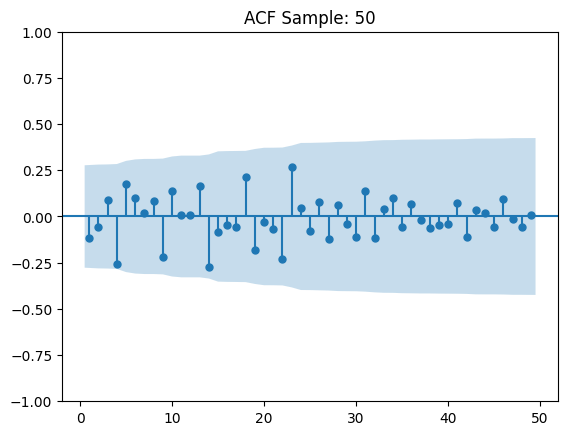

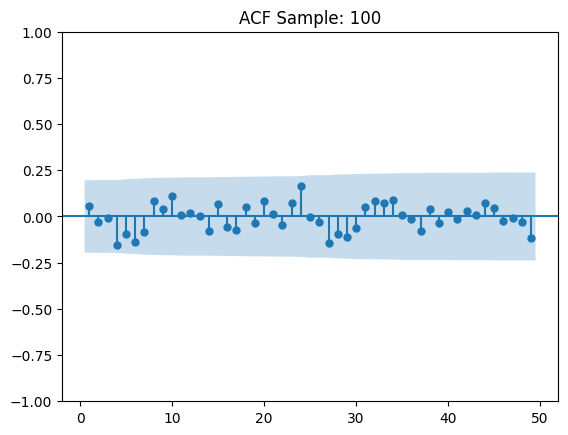

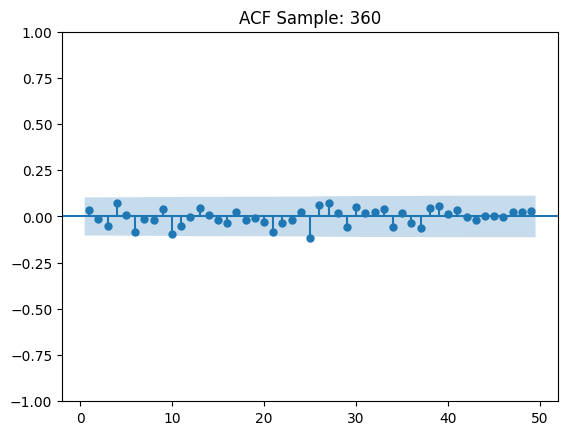

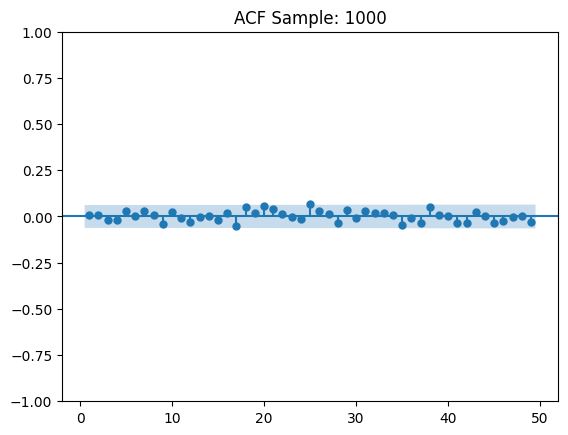

In [23]:
for sample_size in [50, 100, 360, 1000]:
    a = np.array([np.random.randn() for _ in range(1, sample_size + 1)])
    plot_acf(a, lags=range(1, 50), alpha=0.05, title=f"ACF Sample: {sample_size}");

#### 2. A classic example of a non-stationary series are stock prices. Plot the daily closing prices for Amazon stock (contained in gafa_stock), along with the ACF and PACF. Explain how each plot shows that the series is non-stationary and should be differenced.

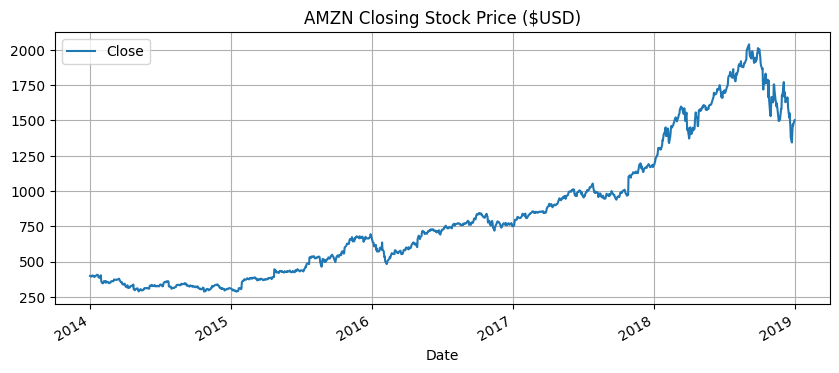

In [104]:
df = pd.read_csv("../data/gafa_stock.csv", index_col=[0])

df = df[df.Symbol == "AMZN"].reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"])

df.plot(
    x="Date", y="Close",
    grid=2, figsize=(10, 4),
    title="AMZN Closing Stock Price ($USD)"
);

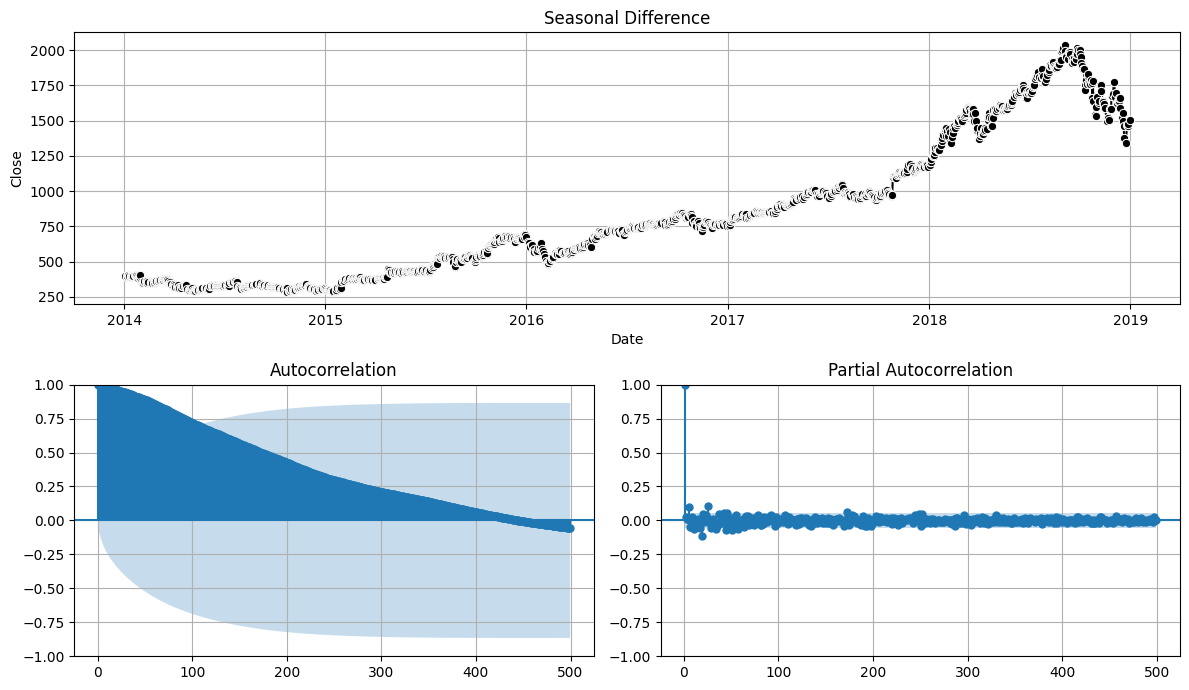

In [107]:
plot_ts_acf(df, x="Date", y="Close", n_lags=range(1, 500))

#### 3. For the following series, find an appropriate Box-Cox transformation and order of differencing in order to obtain stationary data.

##### a) Turkish GDP from global_economy.

In [27]:
df = pd.read_csv("../data/global_economy.csv", index_col=[0])

df = df[df.Country == "Turkey"].reset_index(drop=True)

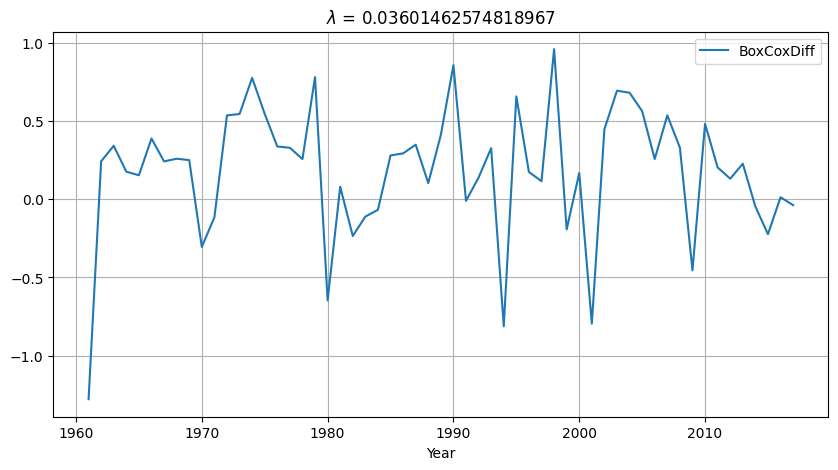

In [42]:
cx, lmbda = boxcox(df["GDP"])

df["BoxCox"] = cx

df["BoxCoxDiff"] = df["BoxCox"].diff(periods=1)

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(x="Year", y="BoxCoxDiff", ax=ax)
ax.set_title(f"$\lambda$ = {lmbda}")
ax.grid(2)

Serie is Stationary with pv: 0.00037


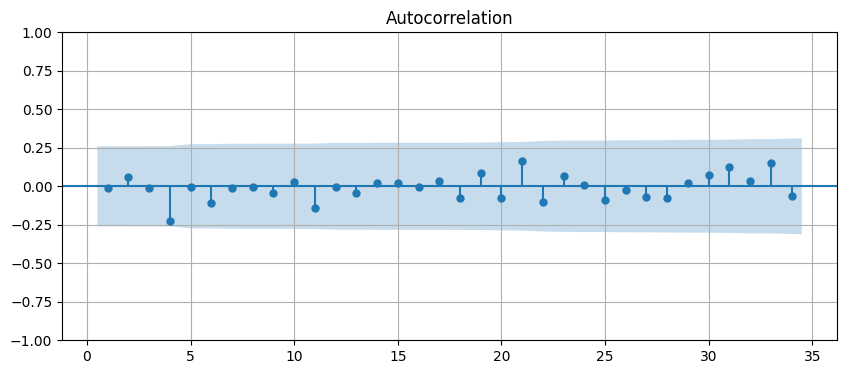

In [53]:
# Ho: Serie is Not Stationary
# Ha: Serie is Stationary

adfs, pv, _, _, _, _ = adfuller(df["BoxCoxDiff"].dropna())

if pv < 0.05:
    print(f"Serie is Stationary with pv: {pv:0.5f}")
else:
    print(f"Serie is Not Stationary!")

fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["BoxCoxDiff"].dropna(), lags=range(1, 35), ax=ax)
ax.grid(2)

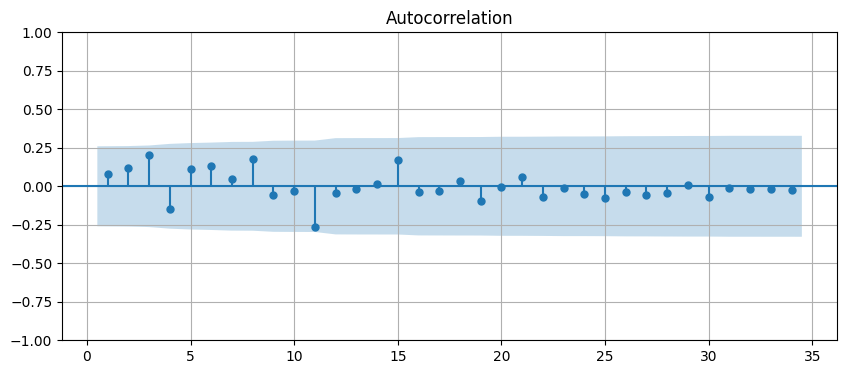

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["GDP"].diff().dropna(), lags=range(1, 35), ax=ax)
ax.grid(2)

##### b) Accommodation takings in the state of Tasmania from aus_accommodation.

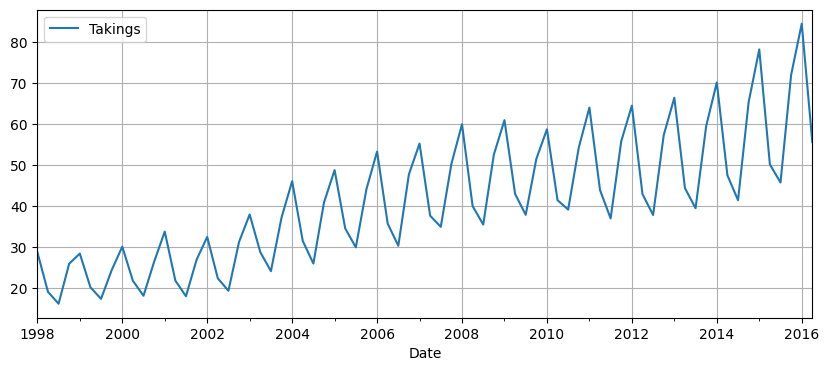

In [65]:
df = pd.read_csv("../data/aus_accommodation.csv", index_col=[0])

df = df[df.State == "Tasmania"].reset_index(drop=True)
df['Date'] = df.Date.apply(lambda x: x.replace(' ', '-'))
df['Date'] = pd.PeriodIndex(df.Date, freq='Q').to_timestamp()

df.plot(
    x="Date", y="Takings",
    figsize=(10, 4), grid=2
);

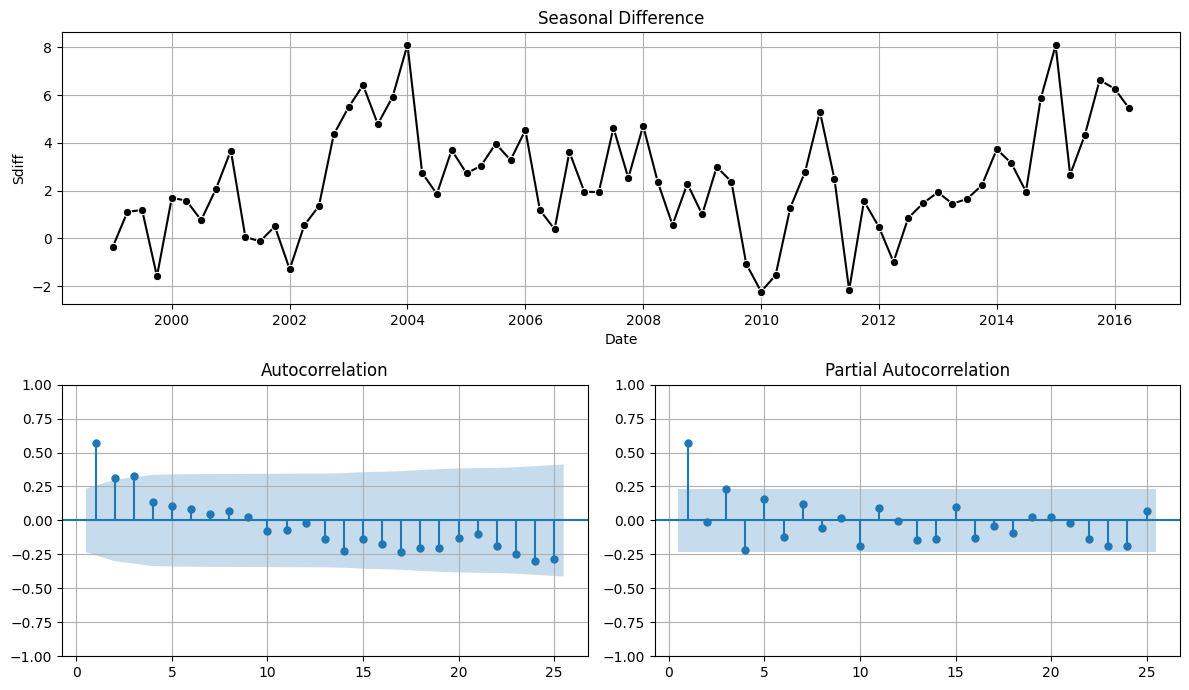

In [83]:
df["Sdiff"] = df["Takings"].diff(periods=4)

plot_ts_acf(df, x="Date", y="Sdiff")

In [84]:
_, pv, _, _, _, _ = adfuller(df["Sdiff"].dropna())

if pv < .05:
    print(f"Series is Stationary with pv: {pv:.04}")

Series is Stationary with pv: 0.0425


##### c) Monthly sales from souvenirs.

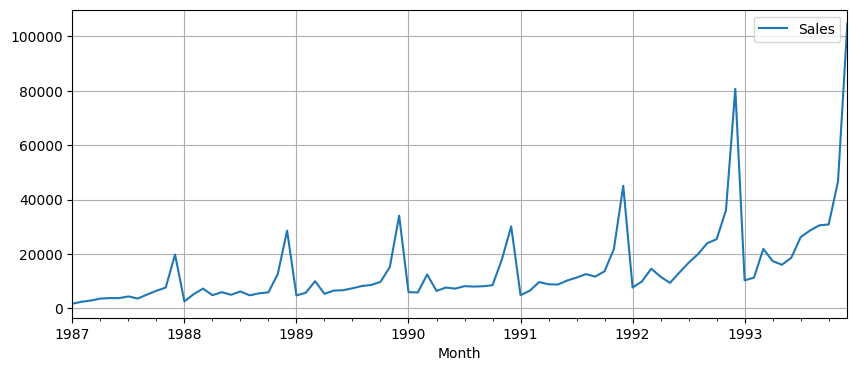

In [88]:
df = pd.read_csv("../data/souvenirs.csv", index_col=[0])

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df.plot(x="Month", y="Sales", figsize=(10, 4), grid=2);

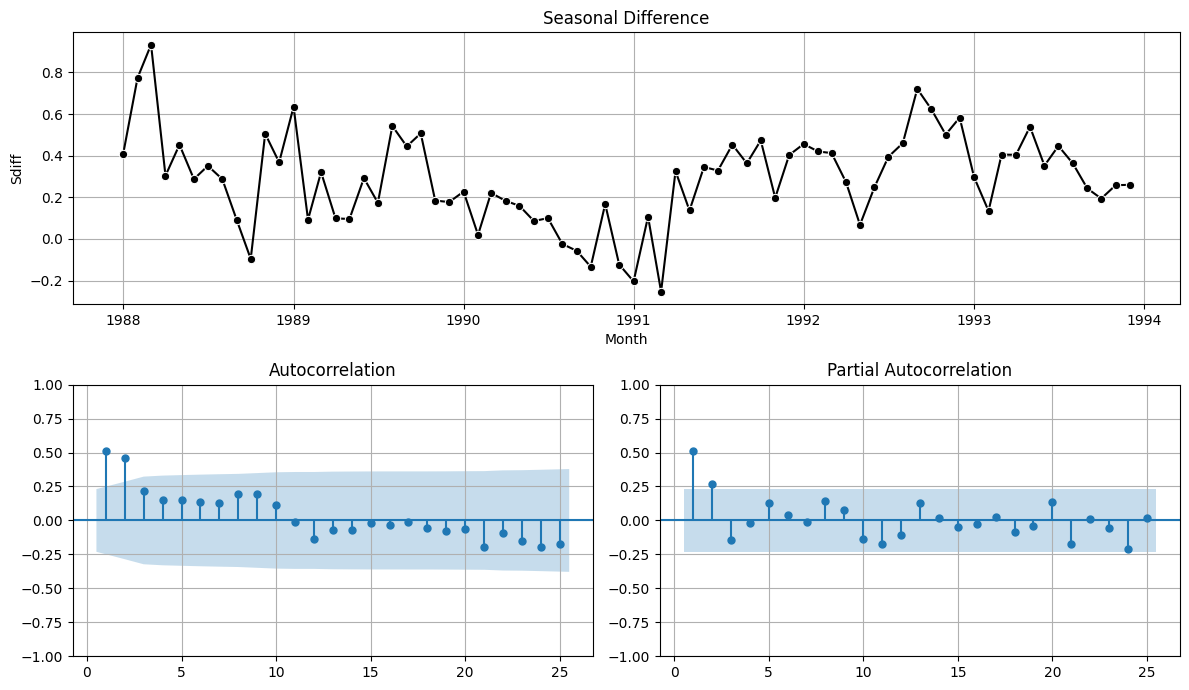

In [92]:
df["Sdiff"] = np.log1p(df["Sales"]).diff(periods=12)

plot_ts_acf(df, x="Month", y="Sdiff")

In [93]:
_, pv, _, _, _, _ = adfuller(df["Sdiff"].dropna())

if pv < .05:
    print(f"Series is Stationary with pv: {pv:.04}")

Series is Stationary with pv: 0.01502


#### 4. For the souvenirs data, write down the differences you chose above using backshift operator notation..

$B^{12}y_t = y_{t-12}$

$z_t = log(y_t)$

$dz_t = z_t - B^{12}z_t$

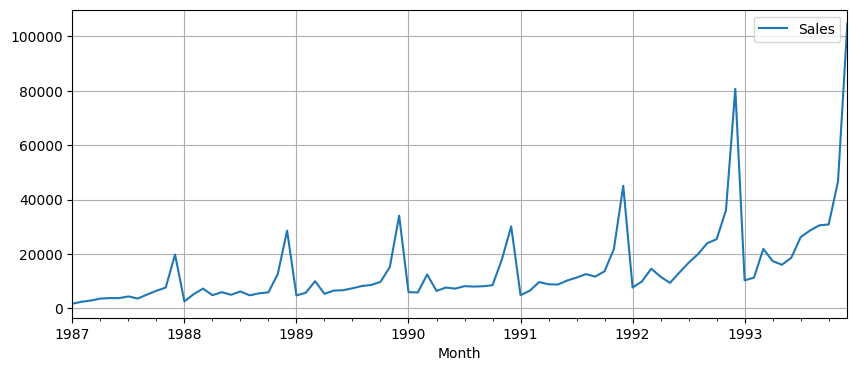

In [108]:
df = pd.read_csv("../data/souvenirs.csv", index_col=[0])

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df.plot(x="Month", y="Sales", figsize=(10, 4), grid=2);

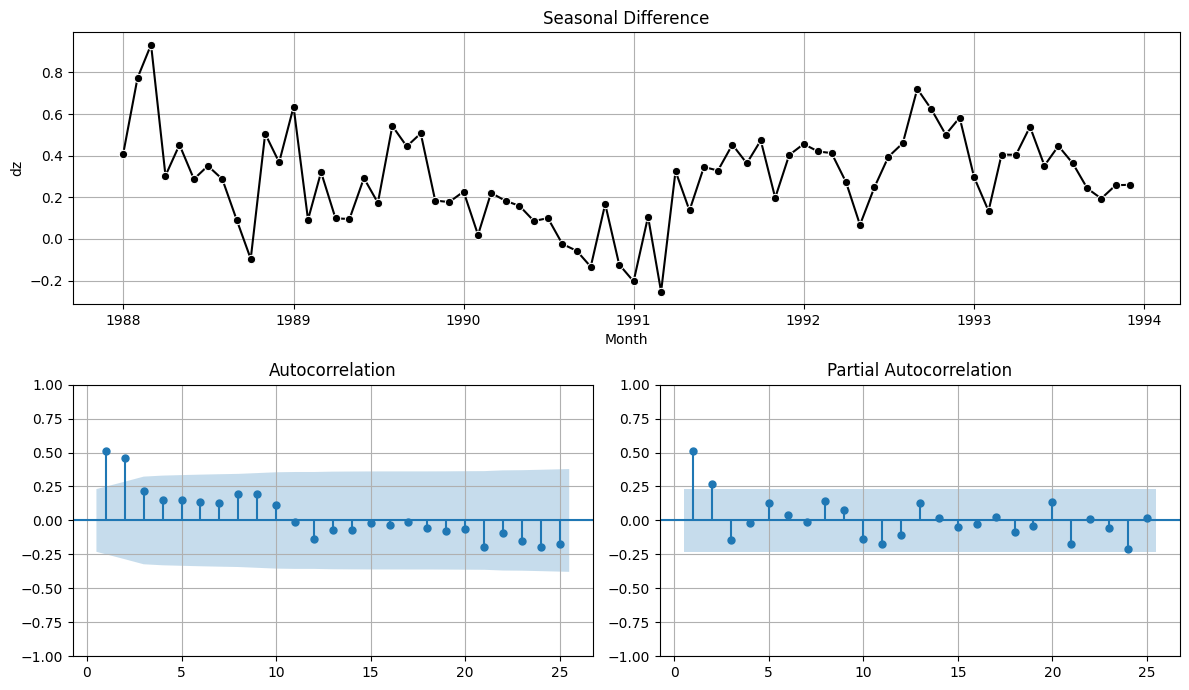

In [116]:
df["dz"] = np.log1p(df["Sales"]).diff(periods=12)

plot_ts_acf(df, x="Month", y="dz")

#### 5. For your retail data (from Exercise 7 in Section 2.10), find the appropriate order of differencing (after transformation if necessary) to obtain stationary data.

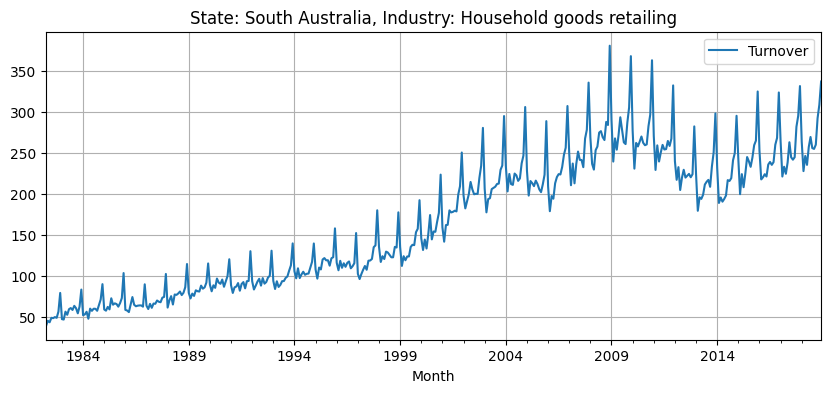

In [132]:
np.random.seed(12345678)

myseries = pd.read_csv("../data/aus_retail.csv", index_col=[0])
myseries = myseries[myseries["Series ID"] == myseries["Series ID"].sample(1).values[0]].reset_index(drop=2)

myseries["Month"] = pd.to_datetime(myseries["Month"], format="%Y %b")

myseries.plot(
    x="Month", y="Turnover",
    title=f"State: {myseries['State'].values[0]}, Industry: {myseries['Industry'].values[0]}",
    grid=2, figsize=(10, 4)
);

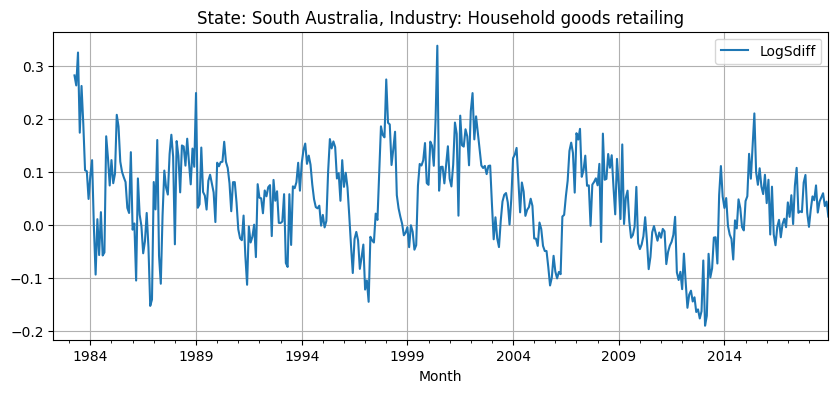

In [137]:
myseries["LogSdiff"] = np.log1p(myseries["Turnover"]).diff(periods=12)

myseries.plot(
    x="Month", y="LogSdiff",
    title=f"State: {myseries['State'].values[0]}, Industry: {myseries['Industry'].values[0]}",
    grid=2, figsize=(10, 4)
);

In [151]:
# No: Not Stationary
# Na: Stationary

_, pv, _, _, _, _ = adfuller(myseries["LogSdiff"].dropna())

# If pvalue is less than alpha, you reject the null hypothesis (ho).
if pv < .05:
    print(f"Serie is Stationary, with p-value: {pv:.4f}")

Serie is Stationary, with p-value: 0.0113


In [153]:
# No: Stationary
# Na: Non Stationary

for reg in ["ct", "c"]:  

    _, pv, _, _ = kpss(myseries["LogSdiff"].dropna(), regression=reg)

    if pv < 0.05:
        print(f"Serie is N Stationary with p-value: {pv:.4f} and Regression: {reg}")

    else:
        print(f"Serie is Stationary, with p-value: {pv:.4f} and Regression: {reg}")

Serie is Stationary, with p-value: 0.1000 and Regression: ct
Serie is N Stationary with p-value: 0.0438 and Regression: c


#### 6. Simulate and plot some data from simple ARIMA models.

##### a) Use the following PYTHON code to generate data from an AR(1) model with ϕ1 = 0.6 and σ2 = 1. The process starts with y1 = 0.

In [173]:
np.random.seed(2)
y = np.zeros(100)
e = np.random.randn(100)

phi = 0.6

y = [phi * y[i-1] + e[i] for i in range(2, y.shape[0])]

sim = pd.DataFrame({"y": y})

##### b) Produce a time plot for the series. How does the plot change as you change ϕ1 ?

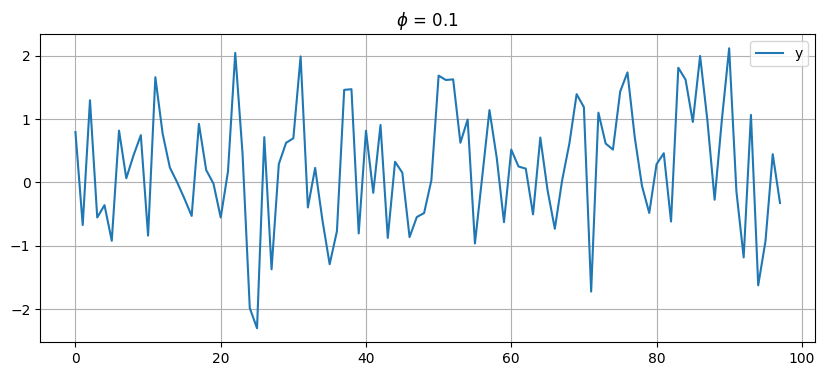

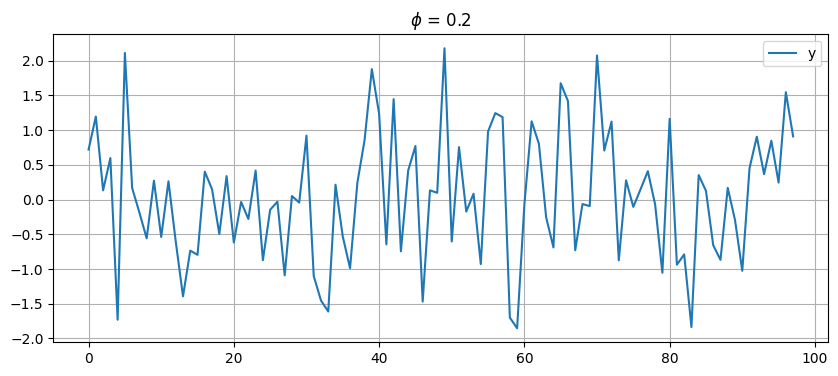

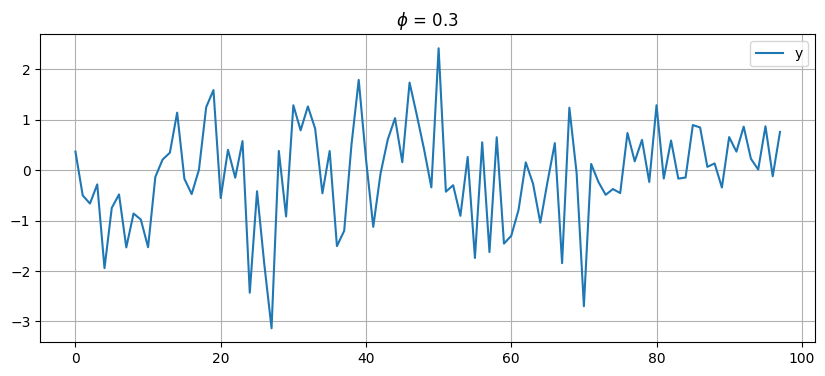

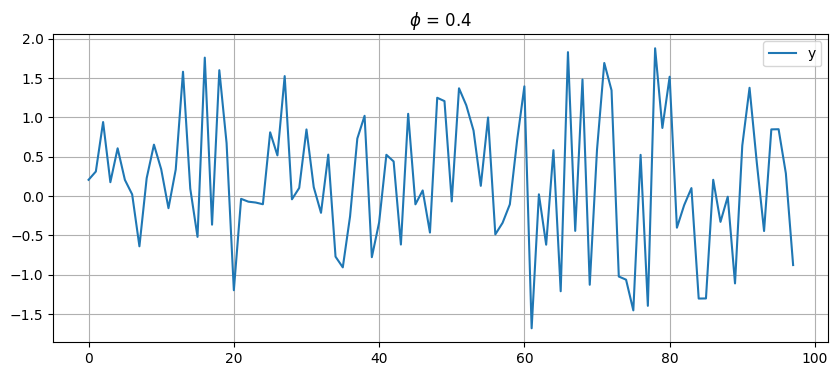

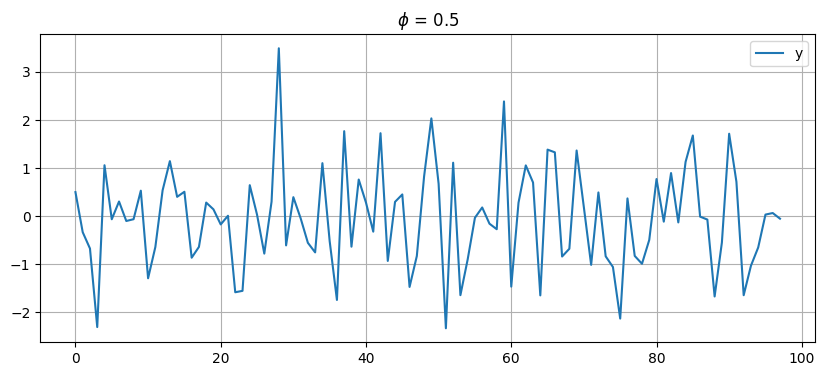

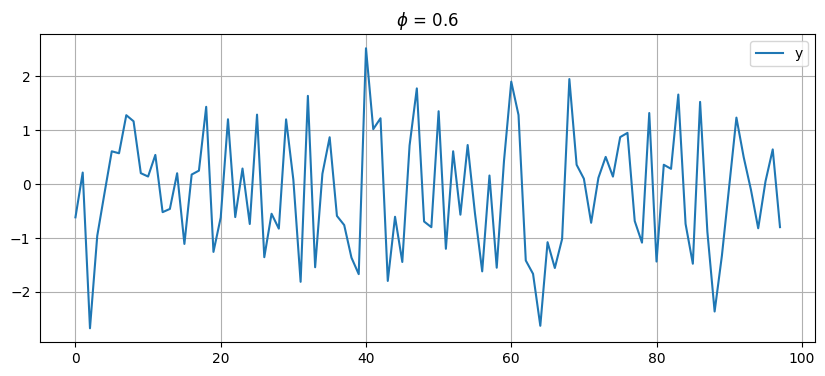

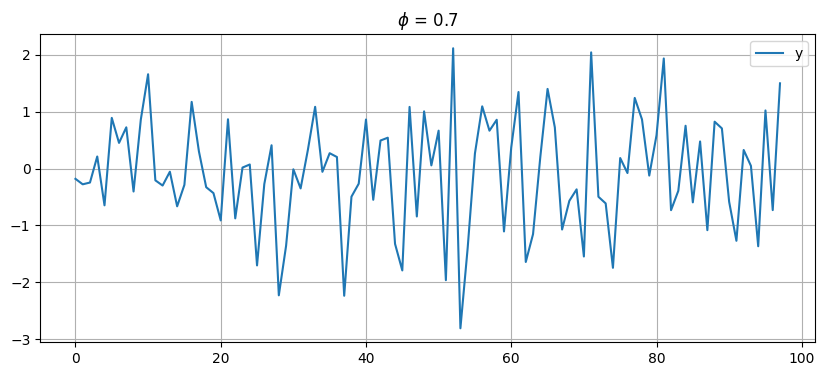

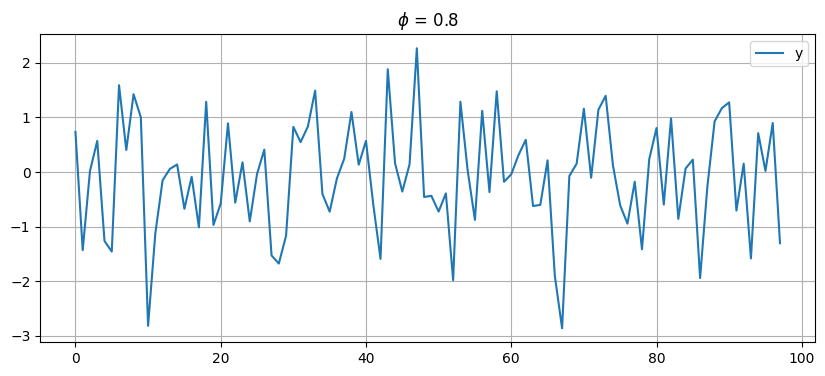

In [184]:
for p in np.arange(0.1, 0.9, 0.1):
    y = np.zeros(100)
    e = np.random.randn(100)

    y = [p * y[i-1] + e[i] for i in range(2, y.shape[0])]
    sim = pd.DataFrame({"y": y})

    sim.plot(
        y="y", grid=2,
        figsize=(10, 4),
        title=f"$\phi$ = {p:.03}"
    );

##### c) Write your own code to generate data from an MA(1) model with θ1 = 0.6 and σ2 = 1 

$y_t = c + e_t + \theta \times e_{t-1}$

$e_t$~$N(0, \sigma²)$

$T = 100$

In [238]:
np.random.seed(2)

c = 10
T = 100
theta = 0.6
sigma_square = 1

y = np.zeros(T)
e = np.random.normal(0, sigma_square, T)

for i in range(2, T):
    y[i] = c + e[i] + theta * e[i-1]

sim = pd.DataFrame({"y": y})

##### d) Produce a time plot for the series. How does the plot change as you change θ1 ?

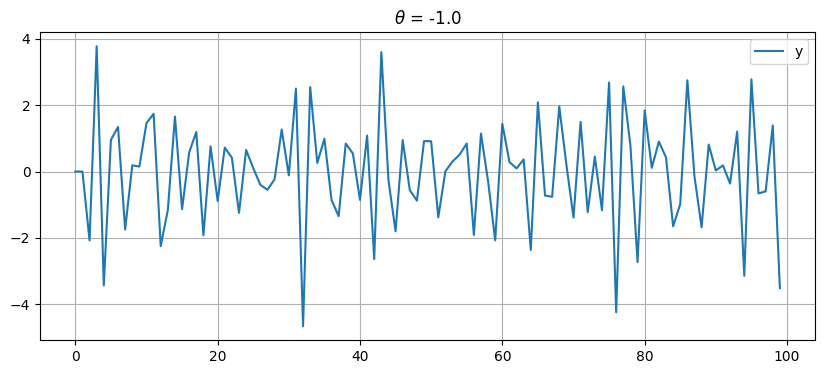

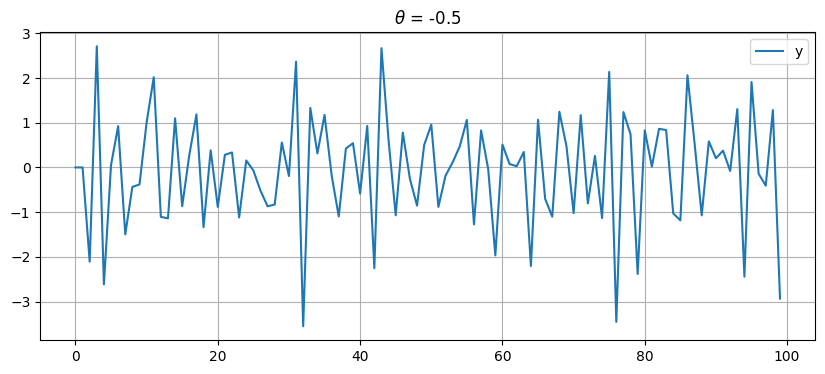

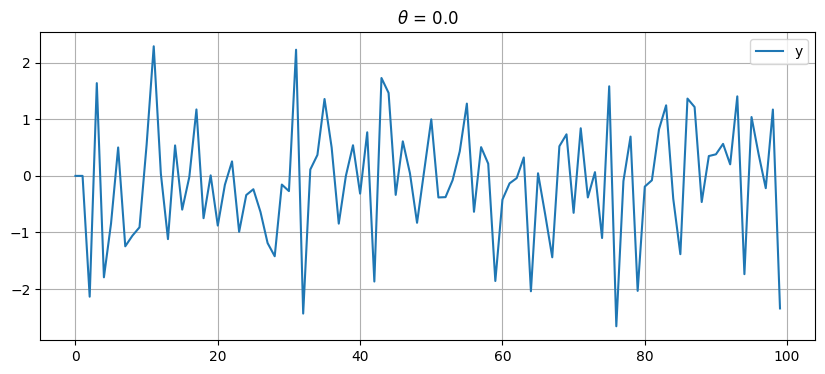

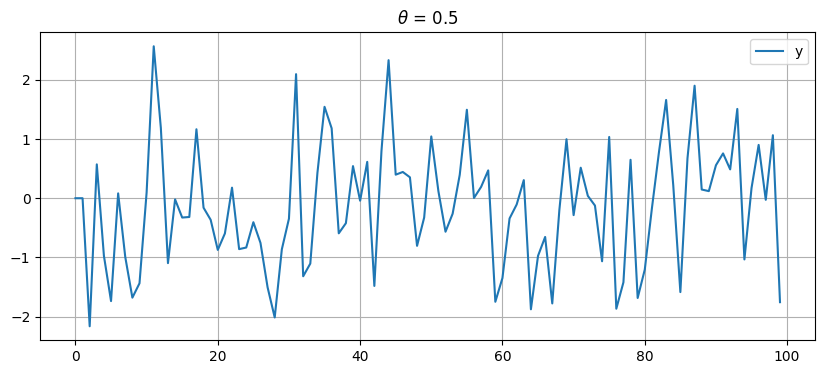

In [239]:
for t in np.arange(-1, 1, 0.5):

    y = np.zeros(T)
    
    for i in range(2, T):
        y[i] = e[i] + t * e[i-1]

    sim = pd.DataFrame({"y": y})

    sim.plot(
        y="y", grid=2,
        figsize=(10, 4),
        title=f"$\\theta$ = {t}"
    );

##### e) Generate data from an ARMA(1,1) model with  ϕ1 = 0.6, θ1 = 0.6 and σ 2 = 1.

In [240]:
np.random.seed(2)

# Variables
# c = 10
T = 100
phi = 0.6
theta = 0.6
sigma_square = 1

# MA
y = np.zeros(T)
e = np.random.normal(0, sigma_square, T)

for i in range(2, T):
    ar = phi * y[i - 1] + e[i]
    ma = t * e[i - 1]

    y[i] = ar + ma
    
sim = pd.DataFrame({"y": y})

##### f) Generate data from an AR(2) model with ϕ1=−0.8, ϕ2=0.3 and σ2=1. (Note that these parameters will give a non-stationary series.)

##### g) Graph the latter two series and compare them.

#### 7. Consider aus_airpassengers, the total number of passengers (in millions) from Australian air carriers for the period 1970-2011.

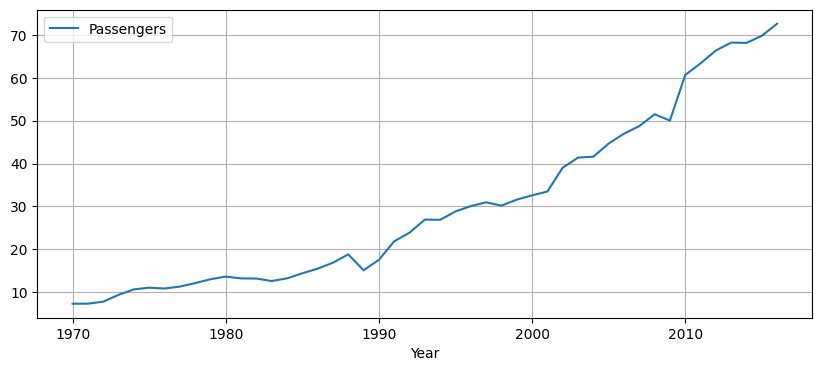

In [246]:
df = pd.read_csv("../data/aus_airpassengers.csv", index_col=[0])

df.plot(x="Year", grid=2, figsize=(10, 4));

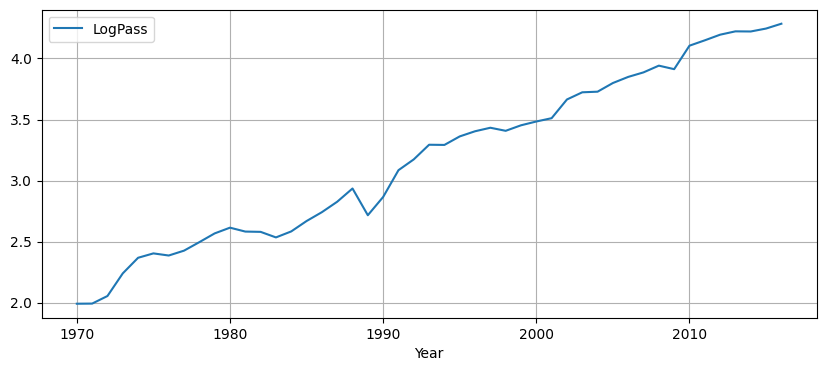

In [249]:
df["LogPass"] = np.log(df["Passengers"])

df.plot(x="Year", y="LogPass", grid=2, figsize=(10, 4));

##### a) Use ARIMA() to find an appropriate ARIMA model. What model was selected. Check that the residuals look like white noise. Plot forecasts for the next 10 periods.

In [261]:
auto_arima = pm.auto_arima(
    df.set_index("Year")['Passengers'],
    
    start_p=1, 
    start_q=1,
    test='adf', 
    max_p=10, 
    max_q=10,

    m=12,
    d=None,
    D=None,
    start_Q=1,
    max_P=5,
    max_D=5,
    max_Q=5,
    max_order=5,

    seasonal=True,
    stepwise=True,
    maxiter=50,
    trace=False,
    error_action='warn',
    suppress_warnings=True
);

In [262]:
auto_arima

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [263]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -98.156
Date:                Thu, 21 Dec 2023   AIC                            200.311
Time:                        22:43:24   BIC                            203.969
Sample:                             0   HQIC                           201.681
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4191      0.367      3.866      0.000       0.700       2.139
sigma2         4.1777      0.489      8.552      0.000       3.220       5.135
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               129.55
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               6.63   Skew:                             1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [264]:
dfr = auto_arima.resid().reset_index()

dfr.columns = ["Year", "Resid"]

dfr["Year"] = df["Year"]

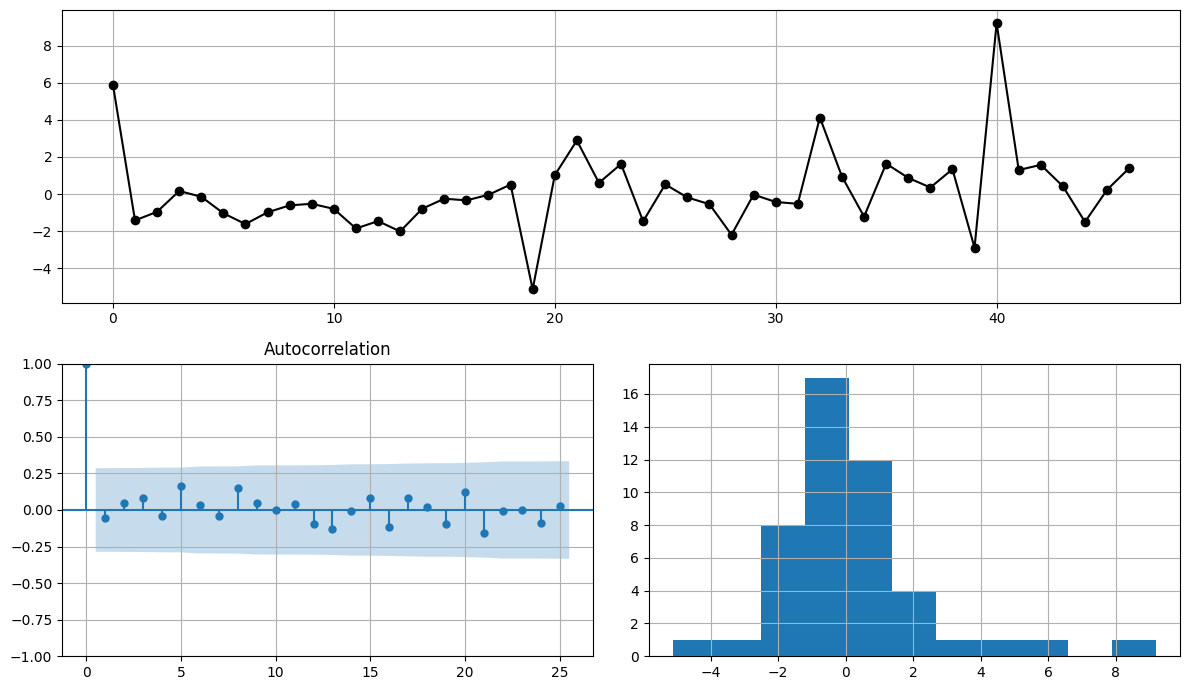

In [265]:
plot_ts_resid(dfr, "Year", "Resid", n_lags=25)

##### b) Write the model in terms of the backshift operator.

ARIMA(1, 1, 1) = $ (1 - \phi_1 B) (1-B)^1y_t = c + (1 + \theta_1 B) * e_t$

ARIMA(0, 1, 0) = $yt = By_t + e_t$

##### c) Plot forecasts from an ARIMA(0,1,0) model with drift and compare these to part a.

In [275]:
forecast = pd.DataFrame({"Year":[y for y in range(df.Year.max() + 1, df.Year.max() + 1 + 10)]})
forecast["Passengers"] = auto_arima.predict(10).values

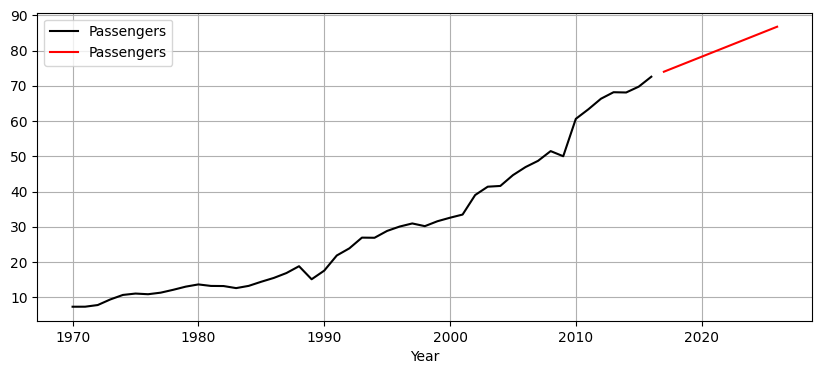

In [280]:
ax = df.plot(x="Year", y="Passengers", figsize=(10, 4), color="k");
forecast.plot(x="Year", y="Passengers", grid=2, ax=ax, color="r");

##### d) Plot forecasts from an ARIMA(2,1,2) model with drift and compare these to parts a and c. Remove the constant and see what happens.

In [282]:
a = pm.ARIMA(
    order=(2, 1, 2),
    seasonal_order=(0, 0, 0, 0)
).fit(df["Passengers"])

a.summary()

forecast = pd.DataFrame({"Year":[y for y in range(df.Year.max() + 1, df.Year.max() + 1 + 10)]})
forecast["Passengers"] = a.predict(10).values

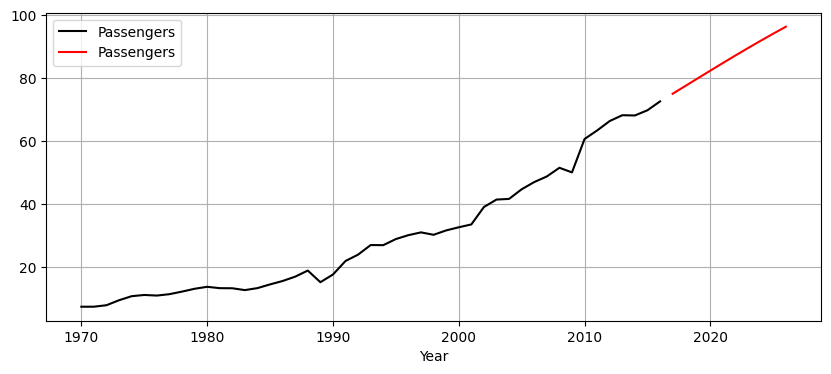

In [283]:
ax = df.plot(x="Year", y="Passengers", figsize=(10, 4), color="k");
forecast.plot(x="Year", y="Passengers", grid=2, ax=ax, color="r");

##### e) Plot forecasts from an ARIMA(0,2,1) model with a constant. What happens?

In [285]:
a = pm.ARIMA(
    order=(0, 2, 1),
    seasonal_order=(0, 0, 0, 0)
).fit(df["Passengers"])

forecast = pd.DataFrame({"Year":[y for y in range(df.Year.max() + 1, df.Year.max() + 1 + 10)]})
forecast["Passengers"] = a.predict(10).values

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 -95.103
Date:                Thu, 21 Dec 2023   AIC                            196.205
Time:                        22:57:19   BIC                            201.625
Sample:                             0   HQIC                           198.226
                                 - 47                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0571      0.022      2.613      0.009       0.014       0.100
ma.L1         -0.9996     22.729     -0.044      0.965     -45.547      43.548
sigma2         3.6822     83.535      0.044      0.965    -160.043     167.407
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):                99.14
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):              14.93   Skew:                             1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

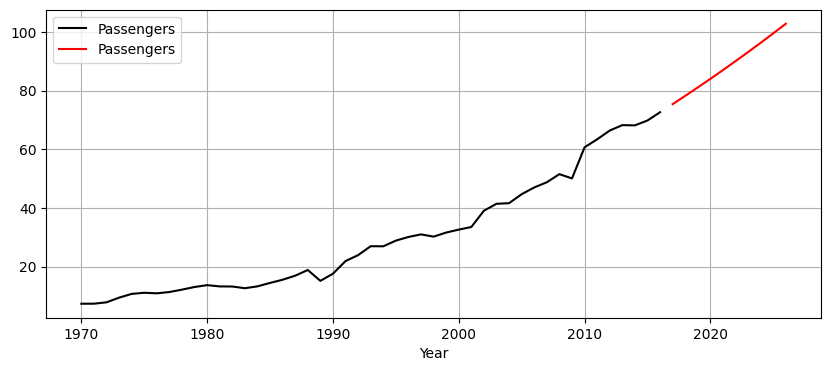

In [286]:
ax = df.plot(x="Year", y="Passengers", figsize=(10, 4), color="k");
forecast.plot(x="Year", y="Passengers", grid=2, ax=ax, color="r");

#### 8. For the United States GDP series (from global_economy):

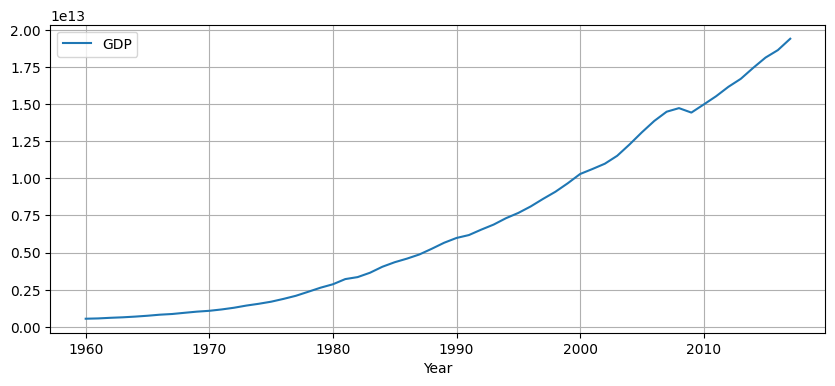

In [8]:
df = pd.read_csv("../data/global_economy.csv", index_col=[0])

df = df[df["Code"] == "USA"].reset_index(drop=True)

df.plot(
    x="Year", y="GDP",
    grid=2, figsize=(10, 4)
);

##### a) if necessary, find a suitable Box-Cox transformation for the data;

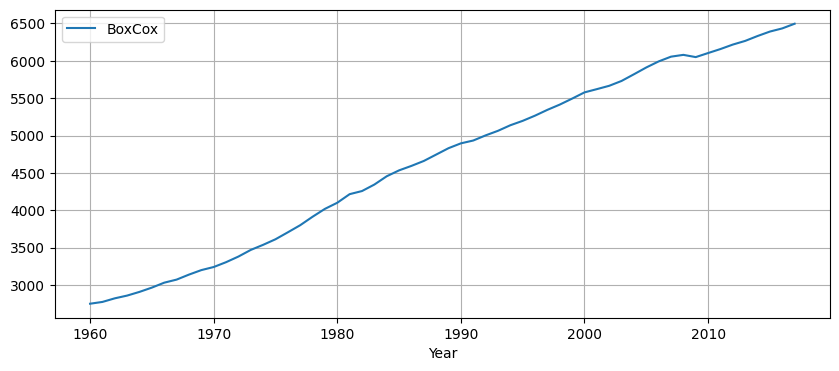

In [12]:
bx, lmbda = boxcox(df["GDP"])

df["BoxCox"] = bx

df.plot(
    x="Year", y="BoxCox",
    grid=2, figsize=(10, 4)
);

##### b) fit a suitable ARIMA model to the transformed data using ARIMA();

In [14]:
a = pm.auto_arima(
    y=df["BoxCox"],
    stepwise=False
)

a

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [15]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -255.821
Date:                Fri, 22 Dec 2023   AIC                            517.643
Time:                        12:47:19   BIC                            523.772
Sample:                             0   HQIC                           520.025
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.6502      6.438      5.382      0.000      22.033      47.268
ar.L1          0.4673      0.089      5.276      0.000       0.294       0.641
sigma2       460.4271     75.699      6.082      0.000     312.059     608.795
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                12.84
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.85
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### c) try some other plausible models by experimenting with the orders chosen;

In [17]:
a = pm.ARIMA(
    order=(0, 2, 1),
    seasonal_order=(0, 0, 0, 0)
).fit(df["GDP"])

forecast = pd.DataFrame({"Year":[y for y in range(df.Year.max() + 1, df.Year.max() + 1 + 10)]})
forecast["GDP"] = a.predict(10).values

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1527.714
Date:                Fri, 22 Dec 2023   AIC                           3061.428
Time:                        12:48:30   BIC                           3067.504
Sample:                             0   HQIC                          3063.784
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.754e+10   2.34e-13   7.49e+22      0.000    1.75e+10    1.75e+10
ma.L1         -0.6214      0.058    -10.790      0.000      -0.734      -0.509
sigma2      3.095e+22   8.22e-25   3.76e+46      0.000    3.09e+22    3.09e+22
===================================================================================
Ljung-Box (L1) (Q):                   3.03   Jarque-Bera (JB):               247.47
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):              19.55   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

##### d) choose what you think is the best model and check the residual diagnostics;

In [22]:
df["resid"] = a.resid()

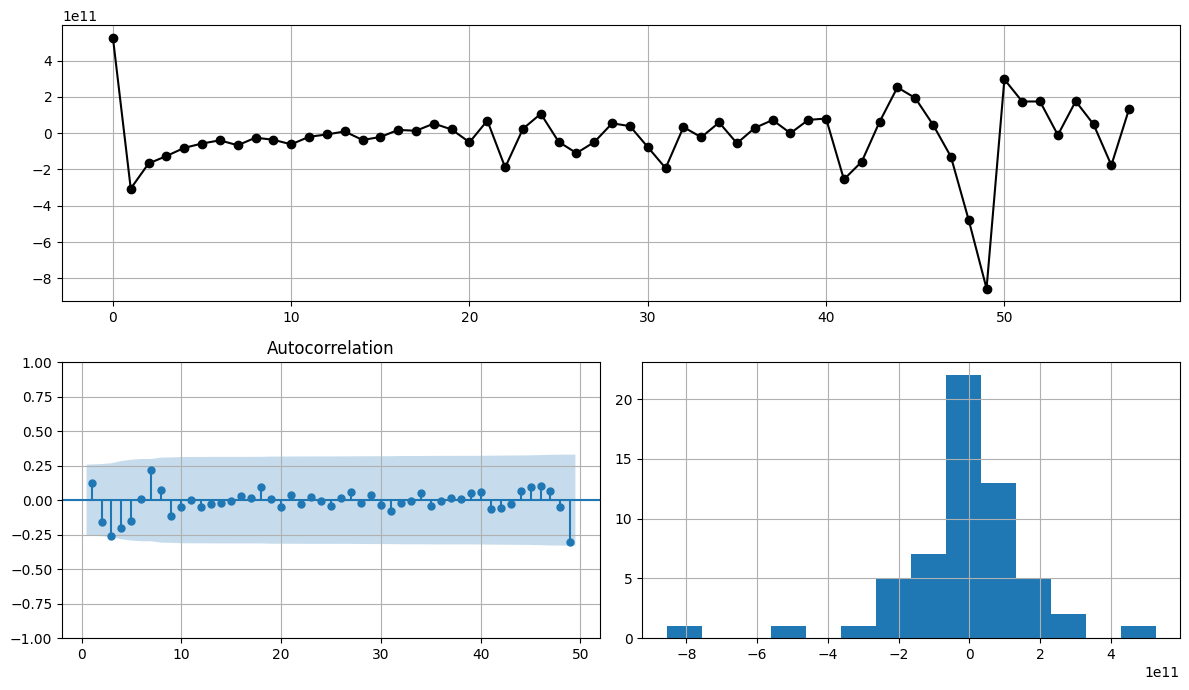

In [24]:
plot_ts_resid(df, x="Year", y="resid", n_lags=range(1, 50))

##### e) produce forecasts of your fitted model. Do the forecasts look reasonable?

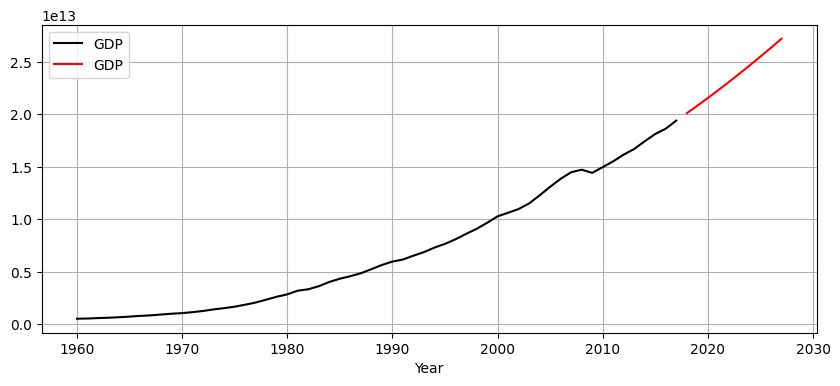

In [25]:
ax = df.plot(x="Year", y="GDP", figsize=(10, 4), color="k");
forecast.plot(x="Year", y="GDP", grid=2, ax=ax, color="r");

##### f) compare the results with what you would obtain using ETS() (with no transformation).

In [27]:
ae = AutoETS().fit(df["GDP"].to_numpy())

In [28]:
ae.model_

{'loglik': -1590.062683329858,
 'aic': 3190.125366659716,
 'bic': 3200.427581712448,
 'aicc': 3191.279212813562,
 'mse': 2.8216355272400266e+22,
 'amse': 1.0174686349826413e+23,
 'fit': results(x=array([9.99892219e-01, 2.00057712e-01, 5.00873208e+11, 4.21136403e+10]), fn=3180.125366659716, nit=191, simplex=array([[9.99892219e-01, 2.00057712e-01, 5.00873208e+11, 4.21136403e+10],
        [9.99886474e-01, 2.00058983e-01, 5.00745406e+11, 4.21587655e+10],
        [9.99889366e-01, 2.00058588e-01, 5.00684371e+11, 4.20707989e+10],
        [9.99889437e-01, 2.00057831e-01, 5.00905190e+11, 4.20378655e+10],
        [9.99887593e-01, 2.00058474e-01, 5.00774016e+11, 4.22209427e+10]])),
 'residuals': array([ 0.00057672, -0.03787729,  0.00675136, -0.00784761,  0.0142846 ,
         0.02540805,  0.03576514, -0.002416  ,  0.03563159,  0.02260347,
        -0.0031349 ,  0.02925555,  0.04002042,  0.05222204,  0.02035245,
         0.0270804 ,  0.04694416,  0.04354948,  0.05928591,  0.04380529,
         0.0153

In [37]:
forecast = pd.DataFrame({"Year":[y for y in range(df.Year.max() + 1, df.Year.max() + 1 + 10)]})
forecast["GDP"] = ae.predict(10)["mean"]

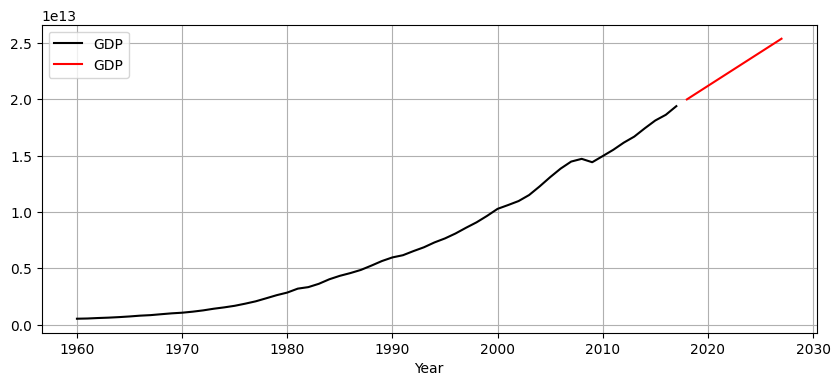

In [38]:
ax = df.plot(x="Year", y="GDP", figsize=(10, 4), color="k");
forecast.plot(x="Year", y="GDP", grid=2, ax=ax, color="r");

#### 9. Consider aus_arrivals, the quarterly number of international visitors to Australia from several countries for the period 1981 Q1 – 2012 Q3.

In [41]:
df = pd.read_csv("../data/aus_arrivals.csv", index_col=[0])
df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

In [45]:
df.Origin.unique()

array(['Japan', 'NZ', 'UK', 'US'], dtype=object)

##### a) Select one country and describe the time plot.

In [47]:
df = df[df.Origin == "UK"].reset_index(drop=True)

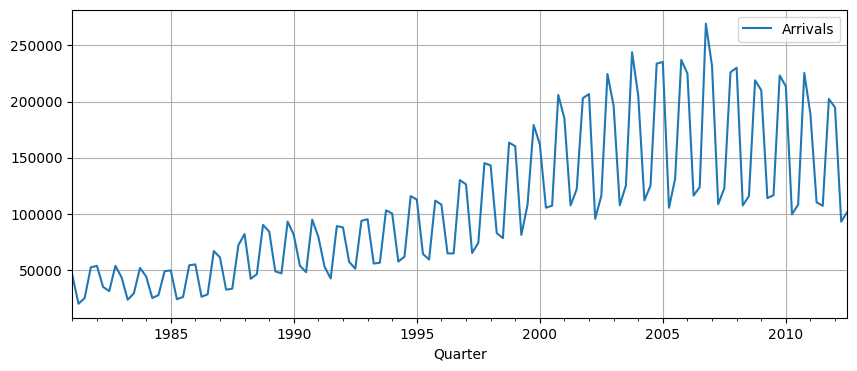

In [52]:
df.plot(
    x="Quarter", y="Arrivals",
    grid=2, figsize=(10, 4)
);

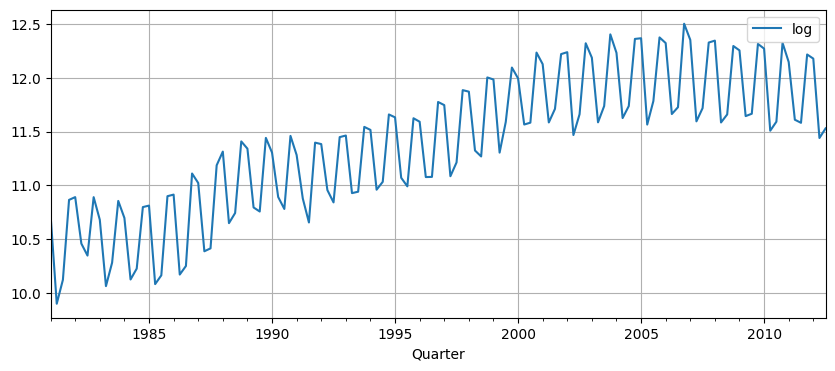

In [60]:
df["log"] = np.log1p(df["Arrivals"])

df.plot(
    x="Quarter", y="log",
    grid=2, figsize=(10, 4)
);

##### b) Use differencing to obtain stationary data.

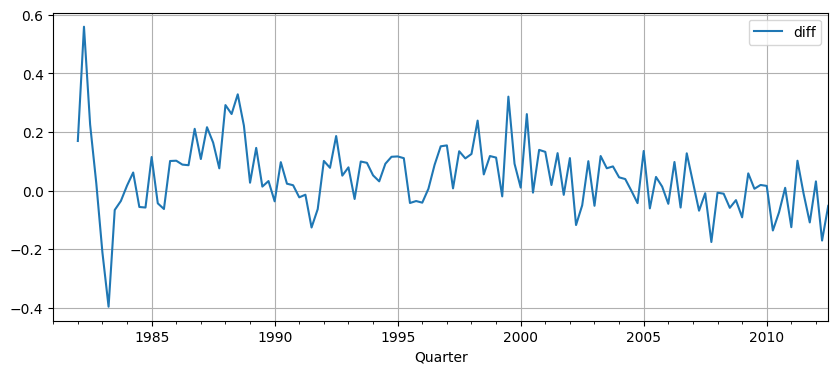

In [62]:
df["diff"] = df["log"].diff(4)#.diff()

df.plot(
    x="Quarter", y="diff",
    grid=2, figsize=(10, 4)
);

##### c) What can you learn from the ACF graph of the differenced data?

Looks like white noise with a MA 2 component. 

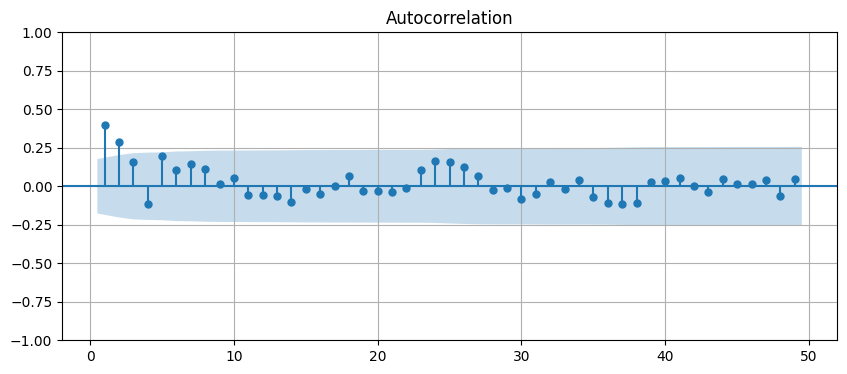

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["diff"].dropna(), ax=ax, lags=range(1, 50))
ax.grid(2)

##### d) What can you learn from the PACF graph of the differenced data?

Maybe a need more one diff and have a significant spike on lag 4 and 5.

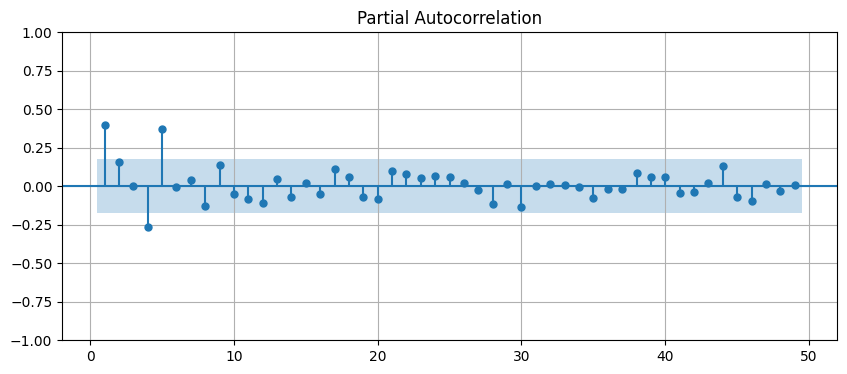

In [67]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df["diff"].dropna(), ax=ax, lags=range(1, 50))
ax.grid(2)

##### e) What model do these graphs suggest?

SARIMA(p, d, q)(P, D, Q, m)

SARIMA(2, 0, 2)(1, 1, 0, 4)

- Non Seasonal AR(2) because have two significant spikes at PACF (without seasonal spike).
- Seasonal AR(1) because have one significant spike at lag 4 on PACF.

- Seasonal Difference for stationary.

- Non Seasonal MA(2) because have significant spike at lag 2 on ACF.
- Seasonal MA(0) because have none significant spike on ACF at seasonal lags (4, 8, 12...).

##### f) Does ARIMA() give the same model that you chose? If not, which model do you think is better?

In [70]:
a = pm.auto_arima(
    df["log"],
    stepwise=False
)

a

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [71]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 119.680
Date:                Fri, 22 Dec 2023   AIC                           -225.360
Time:                        13:30:59   BIC                           -205.506
Sample:                             0   HQIC                          -217.294
                                - 127                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0228      0.009      2.625      0.009       0.006       0.040
ar.L1          0.0011      0.004      0.277      0.782      -0.007       0.009
ar.L2         -0.9990      0.001   -882.567      0.000      -1.001      -0.997
ma.L1         -0.4430      0.100     -4.438      0.000      -0.639      -0.247
ma.L2          0.8338      0.083     10.013      0.000       0.671       0.997
ma.L3         -0.4390      0.118     -3.732      0.000      -0.670      -0.208
sigma2         0.0085      0.001      8.624      0.000       0.007       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                10.74
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
a = pm.ARIMA(
    order=(2, 0, 2),
    seasonal_order=(1, 1, 0, 4)
).fit(df["log"])

a

ARIMA(order=(2, 0, 2), seasonal_order=(1, 1, 0, 4))

In [76]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  127
Model:             SARIMAX(2, 0, 2)x(1, 1, [], 4)   Log Likelihood                 116.552
Date:                            Fri, 22 Dec 2023   AIC                           -219.104
Time:                                    13:32:20   BIC                           -199.419
Sample:                                         0   HQIC                          -211.108
                                            - 127                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0156      0.017      0.942      0.346      -0.017       0.048
ar.L1         -0.0131      0.109     -0.120      0.905      -0.227       0.201
ar.L2          0.7768      0.088      8.870      0.000       0.605       0.948
ma.L1          0.5169      0.210      2.465      0.014       0.106       0.928
ma.L2         -0.4737      0.152     -3.109      0.002      -0.772      -0.175
ar.S.L4       -0.5252      0.075     -6.967      0.000      -0.673      -0.377
sigma2         0.0086      0.001      6.575      0.000       0.006       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                26.32
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
df.tail(2)

,Quarter,Origin,Arrivals,diff,log
125,2012-04-01,UK,92970,-0.170127,11.440043
126,2012-07-01,UK,101690,-0.051731,11.529694


In [95]:
forecast = pd.date_range(
    start=df.Quarter.max(),
    end=df.Quarter.max() + pd.offsets.DateOffset(years=4),
    freq="QS-JAN"
)[1:]

forecast = pd.DataFrame(forecast)

forecast.columns = ["Quarter"]

forecast["log"] = a.predict(len(forecast)).values

In [100]:
df["Arr"] = np.expm1(df["log"])
forecast["YhatArr"] = np.expm1(forecast["log"])

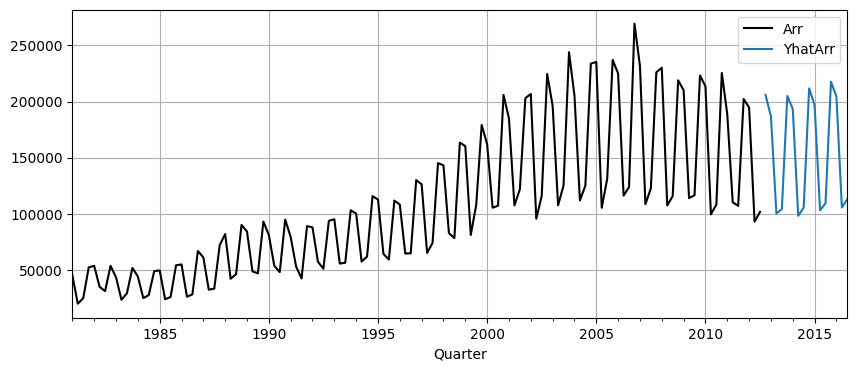

In [101]:
ax = df.plot(x="Quarter", y="Arr", figsize=(10, 4), color="k")
forecast.plot(x="Quarter", y="YhatArr", grid=2, ax=ax);

##### a) Write the model in terms of the backshift operator, then without using the backshift operator.

SARIMA(2, 0, 2)(1, 1, 0, 4)

$(1 - \phi_{1}B) (1 - \phi_{2}B^2) (1 - \Phi_{1}B^{4}) (1 - B⁴)y_t = (1 + \theta_1B) (1 + \theta_2B^2)$

#### 10. Choose a series from us_employment, the total employment in different industries in the United States.

<Axes: xlabel='Month'>

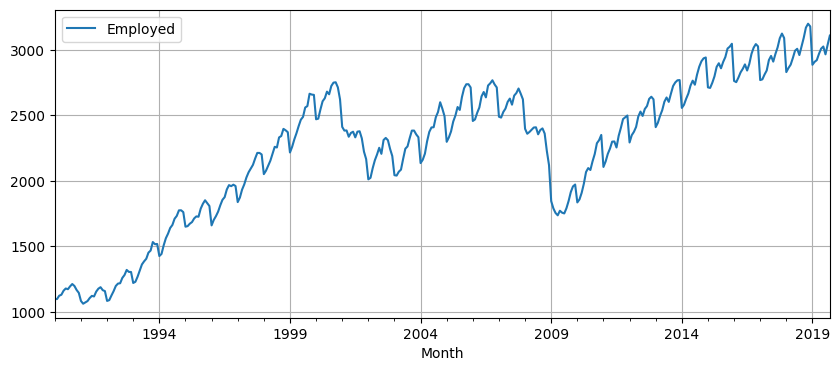

In [118]:
df = pd.read_csv("../data/us_employment.csv", index_col=[0])

df.Month = pd.to_datetime(df.Month, format="%Y %b")

df = df[df["Series_ID"] == "TEMPHELPN"].reset_index(drop=True).dropna().reset_index(drop=True)

df.plot(x="Month", y="Employed", figsize=(10, 4), grid=2)

##### a) Produce an STL decomposition of the data and describe the trend and seasonality.

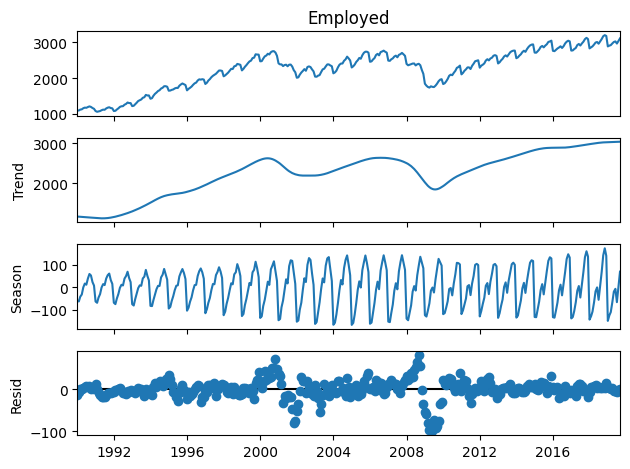

In [115]:
stl = STL(
    df.set_index("Month")["Employed"]
).fit()

stl.plot();

##### b) Do the data need transforming? If so, find a suitable transformation.

<Axes: xlabel='Month'>

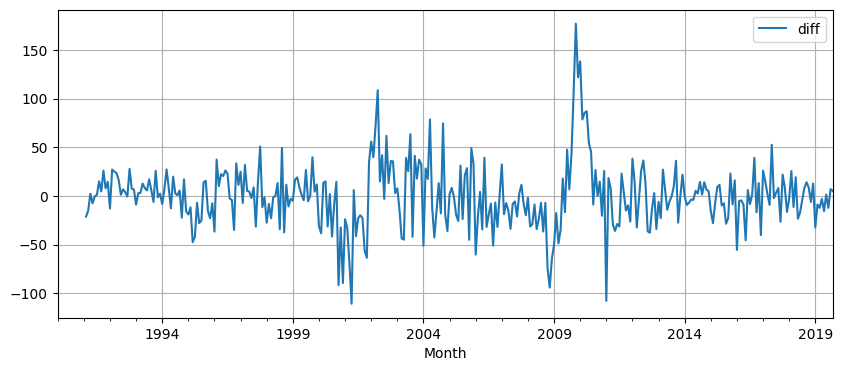

In [127]:
df["diff"] = df.Employed.diff(12).diff()

df.plot(x="Month", y="diff", figsize=(10, 4), grid=2)

##### c) Are the data stationary? If not, find an appropriate differencing which yields stationary data.

Serie is Stationary with pv: 0.00000


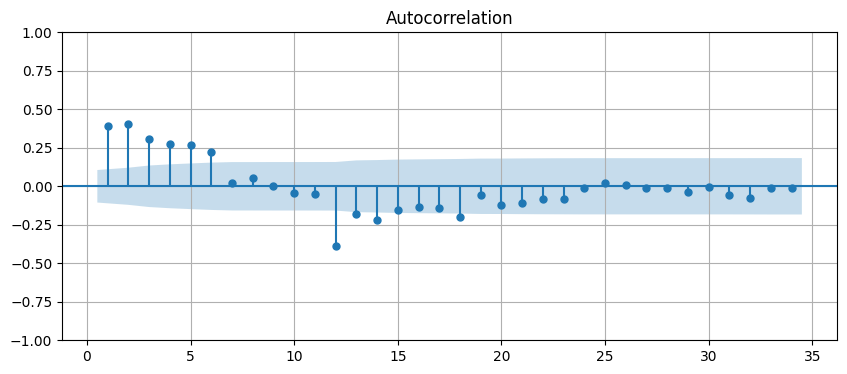

In [129]:
# Ho: Serie is Not Stationary
# Ha: Serie is Stationary

adfs, pv, _, _, _, _ = adfuller(df["diff"].dropna())

if pv < 0.05:
    print(f"Serie is Stationary with pv: {pv:0.5f}")
else:
    print(f"Serie is Not Stationary!")

fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["diff"].dropna(), lags=range(1, 35), ax=ax)
ax.grid(2)

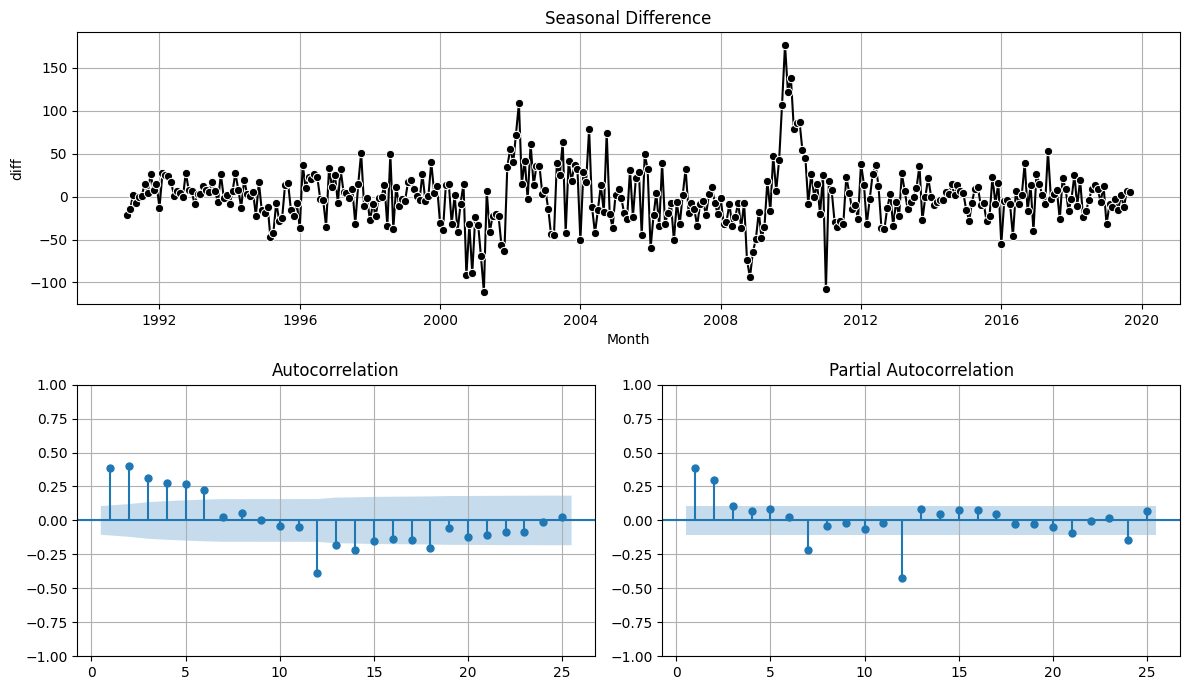

In [130]:
plot_ts_acf(df, "Month", "diff")

##### d) Identify a couple of ARIMA models that might be useful in describing the time series. Which of your models is the best according to their AICc values?

SARIMA(p, d, q)(P, D, Q, m)

SARIMA(2, 1, 0)(2, 1, 1, 12)

- Non Seasonal AR(2) because have two significant spikes at PACF (without seasonal spike).
- Seasonal AR(2) because have one significant spike at lag 4 on PACF.

- Seasonal and Non Seasonal Difference for stationary.

- Non Seasonal MA(0) because is exponencial ???
- Seasonal MA(1) because have one significant spike on ACF at seasonal lags (12).

In [133]:
a = pm.auto_arima(df["diff"].dropna())

a

ARIMA(order=(3, 0, 2), scoring_args={}, suppress_warnings=True)

In [135]:
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  344
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1637.406
Date:                Fri, 22 Dec 2023   AIC                           3288.812
Time:                        14:06:31   BIC                           3315.696
Sample:                             0   HQIC                          3299.519
                                - 344                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0041      0.015     -0.277      0.782      -0.033       0.025
ar.L1          1.7344      0.107     16.230      0.000       1.525       1.944
ar.L2         -0.6279      0.172     -3.659      0.000      -0.964      -0.292
ar.L3         -0.1247      0.071     -1.750      0.080      -0.264       0.015
ma.L1         -1.5564      0.102    -15.296      0.000      -1.756      -1.357
ma.L2          0.5639      0.102      5.546      0.000       0.365       0.763
sigma2       792.3029     49.892     15.880      0.000     694.517     890.089
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                38.30
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.03
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### e) Estimate the parameters of your best model and do diagnostic testing on the residuals. Do the residuals resemble white noise? If not, try to find another ARIMA model which fits better.

##### f) Forecast the next 3 years of data. Get the latest figures from https://fred.stlouisfed.org/categories/11 to check the accuracy of your forecasts.

##### g) Eventually, the prediction intervals are so wide that the forecasts are not particularly useful. How many years of forecasts do you think are sufficiently accurate to be usable?.

#### 11 + 12. Choose one of the following seasonal time series: the Australian production of electricity, cement, or gas (from aus_production).

In [5]:
df = pd.read_csv("../data/aus_production.csv", index_col=[0])

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

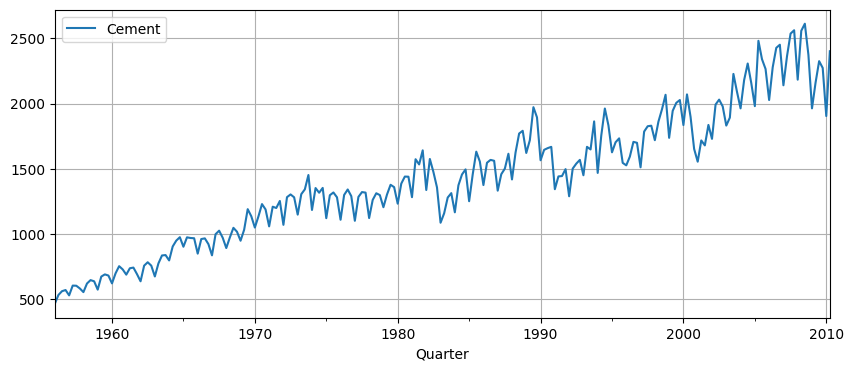

In [6]:
df.plot(
    x="Quarter", y="Cement", grid=2,
    figsize=(10, 4)
);

In [ ]:
df = df[df["Quarter"] >= "1980"].reset_index(drop=True)

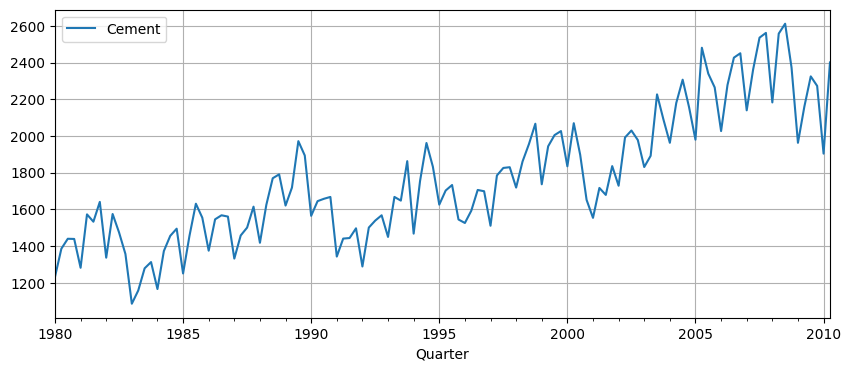

In [10]:
df.plot(
    x="Quarter", y="Cement", grid=2,
    figsize=(10, 4)
);

##### a) Do the data need transforming? If so, find a suitable transformation.

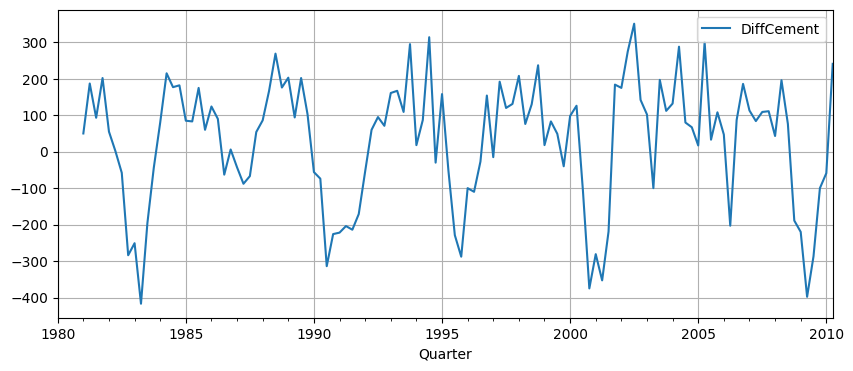

In [13]:
df["DiffCement"] = df["Cement"].diff(4)

df.plot(
    x="Quarter", y="DiffCement", grid=2,
    figsize=(10, 4)
);

##### b) Are the data stationary? If not, find an appropriate differencing which yields stationary data.

In [19]:
# Ho: Serie is Stationary
# Ha: Serie is not Stationary

_, pv, _, _, _, _ = adfuller(df["DiffCement"].dropna())

if pv < 0.05:
    print(f"Serie is Stationary with pv: {pv:0.5f}")

Serie is Stationary with pv: 0.00000


##### c) Identify a couple of ARIMA models that might be useful in describing the time series. Which of your models is the best according to their AIC values?

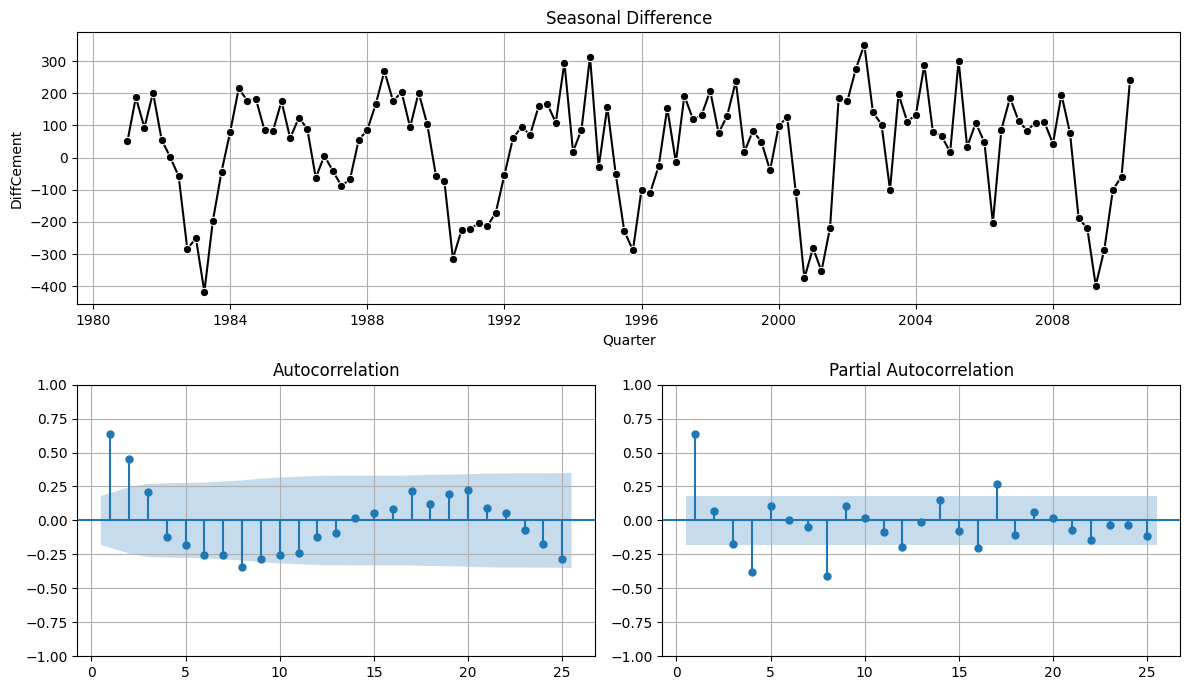

In [20]:
plot_ts_acf(df, x="Quarter", y="DiffCement")

SARIMA(p, d, q)(P, D, Q, m)

SARIMA(1, 0, 2)(2, 1, 1, 4)

- p = 1, Significant spike on lag 1 on PACF.
- d = 0, Non Seasonal Differencing.
- q = 2, Significant spike at lag 2 on ACF.
- P = 2, Significant spikes on lag 4 and 8 on PACF.
- D = 1, Seasonal Differencing.
- Q = 1, Significant spike on lag 8 on ACF.
- m = 4, Quarter dataset.

##### d) Do the data need transforming? If so, find a suitable transformation.Estimate the parameters of your best model and do diagnostic testing on the residuals. Do the residuals resemble white noise? If not, try to find another ARIMA model which fits better.


In [26]:
a = pm.ARIMA(
    order=(1, 0, 2),
    seasonal_order=(2, 1, 1, 4)
).fit(df["Cement"])

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  122
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 4)   Log Likelihood                -712.900
Date:                             Sat, 23 Dec 2023   AIC                           1441.800
Time:                                     15:14:11   BIC                           1463.966
Sample:                                          0   HQIC                          1450.800
                                             - 122                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2966      7.377      1.396      0.163      -4.163      24.756
ar.L1          0.7639      0.130      5.891      0.000       0.510       1.018
ma.L1         -0.1455      0.143     -1.017      0.309      -0.426       0.135
ma.L2          0.1653      0.152      1.088      0.277      -0.132       0.463
ar.S.L4       -0.0240      0.136     -0.176      0.860      -0.291       0.243
ar.S.L8       -0.2572      0.125     -2.051      0.040      -0.503      -0.011
ma.S.L4       -0.6965      0.118     -5.916      0.000      -0.927      -0.466
sigma2      9947.5681   1453.239      6.845      0.000    7099.273    1.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.80   Prob(JB):                         0.58
Heteroskedasticity (H):               2.65   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
b = pm.auto_arima(
    df["Cement"]
)

print(b)

b.summary()

 ARIMA(4,1,4)(0,0,0)[0]          


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -739.011
Date:                Sat, 23 Dec 2023   AIC                           1496.022
Time:                        15:16:49   BIC                           1521.184
Sample:                             0   HQIC                          1506.241
                                - 122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0992      0.214     -0.463      0.643      -0.519       0.320
ar.L2         -0.1082      0.211     -0.513      0.608      -0.521       0.305
ar.L3         -0.1185      0.214     -0.555      0.579      -0.537       0.300
ar.L4          0.8792      0.211      4.165      0.000       0.465       1.293
ma.L1         -0.1611      0.191     -0.844      0.399      -0.535       0.213
ma.L2         -0.0224      0.135     -0.166      0.868      -0.286       0.241
ma.L3          0.1716      0.140      1.227      0.220      -0.102       0.446
ma.L4         -0.7659      0.136     -5.643      0.000      -1.032      -0.500
sigma2       1.19e+04   1715.253      6.936      0.000    8535.877    1.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.46   Prob(JB):                         0.72
Heteroskedasticity (H):               2.52   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
c = AutoARIMA().fit(df["Cement"].values)

c

AutoARIMA

In [51]:
c.model_

{'coef': {'ar1': -0.1714736582972995,
  'ar2': -0.35589589563426505,
  'ma1': -0.3721783014515771},
 'sigma2': 26444.941303526695,
 'var_coef': array([[1.21615098e-04, 0.00000000e+00, 0.00000000e+00],
        [1.66625576e-05, 5.21318308e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.83013455e-05]]),
 'mask': array([ True,  True,  True]),
 'loglik': -786.0435548005328,
 'aic': 1580.0871096010655,
 'arma': (2, 1, 0, 0, 1, 1, 0),
 'residuals': array([   1.23199912,  128.58559309,   90.65813763,   91.37119   ,
        -104.24591383,  224.94065713,   37.71559668,  218.74191777,
        -218.30596801,  143.06006725, -114.13777273,  -92.92374424,
        -361.40768237, -150.97317439,  -19.29062393,   73.19326549,
         -70.86554702,  167.51921376,  128.52536705,  174.73711684,
        -142.73980464,  123.91570926,  169.43223961,   90.02555196,
         -97.24465928,   76.89430132,   15.87912481,   63.54048434,
        -198.72221637,   10.28116403,  -13.06805299,  161.3526

##### e) Forecast the next 24 months of data using your preferred model.

In [54]:
forecast = pd.date_range(
    start=df.Quarter.max(),
    end=df.Quarter.max() + pd.offsets.DateOffset(years=2),
    freq="QS-DEC"
)

forecast = pd.DataFrame(forecast, columns=["Quarter"])

forecast["MyModelCement"] = a.predict(len(forecast)).values
forecast["AutoArimaCement"] = b.predict(len(forecast)).values
forecast["NixtlaCement"] = c.predict(h=len(forecast))["mean"]

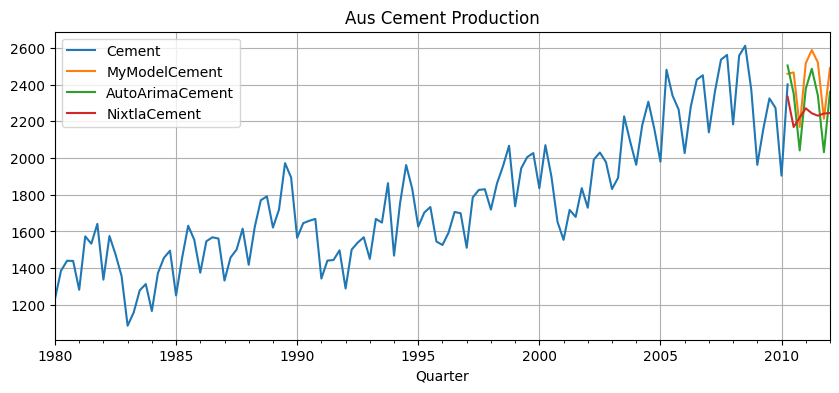

In [55]:
ax = df.plot(
    x="Quarter", y="Cement", 
    figsize=(10, 4), title="Aus Cement Production"
)
forecast.plot(x="Quarter", ax=ax, grid=2);

##### f) Compare the forecasts obtained using ETS().

In [58]:
ets = AutoETS().fit(df["Cement"].values)

forecast["NixtlaETSCement"] = ets.predict(h=len(forecast))["mean"]

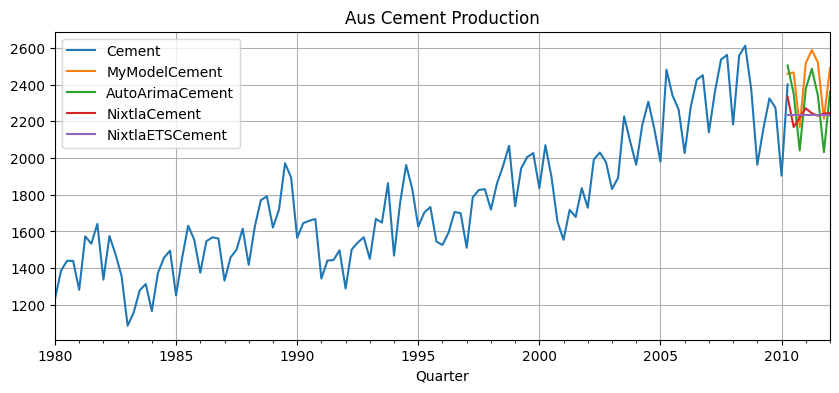

In [60]:
ax = df.plot(
    x="Quarter", y="Cement", 
    figsize=(10, 4), title="Aus Cement Production"
)
forecast.plot(x="Quarter", ax=ax, grid=2);

#### 13. For the Australian tourism data (from tourism):

In [63]:
df = pd.read_csv("../data/tourism.csv", index_col=[0])

df['Quarter'] = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

df.head()

,Quarter,Region,State,Purpose,Trips
1,1998-01-01,Adelaide,South Australia,Business,135.077690
2,1998-04-01,Adelaide,South Australia,Business,109.987316
3,1998-07-01,Adelaide,South Australia,Business,166.034687
4,1998-10-01,Adelaide,South Australia,Business,127.160464
5,1999-01-01,Adelaide,South Australia,Business,137.448533


In [66]:
df[df["Region"] == "Adelaide"].State.unique()

array(['South Australia'], dtype=object)

In [67]:
df[df["Region"] == "Adelaide"].Purpose.unique()

array(['Business', 'Holiday', 'Other', 'Visiting'], dtype=object)

In [71]:
dfr = df[["Quarter", "Region", "Trips"]].groupby(["Quarter", "Region"]).sum().reset_index()

In [72]:
dfr.head()

,Quarter,Region,Trips
0,1998-01-01,Adelaide,658.553895
1,1998-01-01,Adelaide Hills,9.798630
2,1998-01-01,Alice Springs,20.207638
3,1998-01-01,Australia's Coral Coast,132.516409
4,1998-01-01,Australia's Golden Outback,161.726948


In [73]:
dfr.Region.value_counts()

Region
Adelaide                  80
Mallee                    80
North West                80
North Coast NSW           80
New England North West    80
                          ..
East Coast                80
Darwin                    80
Darling Downs             80
Clare Valley              80
Yorke Peninsula           80
Name: count, Length: 76, dtype: int64

##### a) Fit ARIMA models for each time series.

In [75]:
dfr.columns = ["ds", "unique_id", "y"]

In [77]:
try:
    a = AutoARIMA().fit(dfr)
except Exception as e:
    print(e)

auto_arima can only handle univariate time series


In [80]:
sf = StatsForecast(
    models=[AutoARIMA(season_length=4)],
    freq="QS-DEC"
).fit(dfr)

##### b) Produce forecasts of your fitted models.

In [83]:
forecast = sf.predict(h=8)

forecast = forecast.reset_index()

##### c) Check the forecasts for the “Snowy Mountains” and “Melbourne” regions. Do they look reasonable?

In [98]:
dfp = dfr[dfr.unique_id.isin(["Melbourne", "Snowy Mountains"])].reset_index(drop=True)
dfp2 = forecast[forecast.unique_id.isin(["Melbourne", "Snowy Mountains"])].reset_index(drop=True)

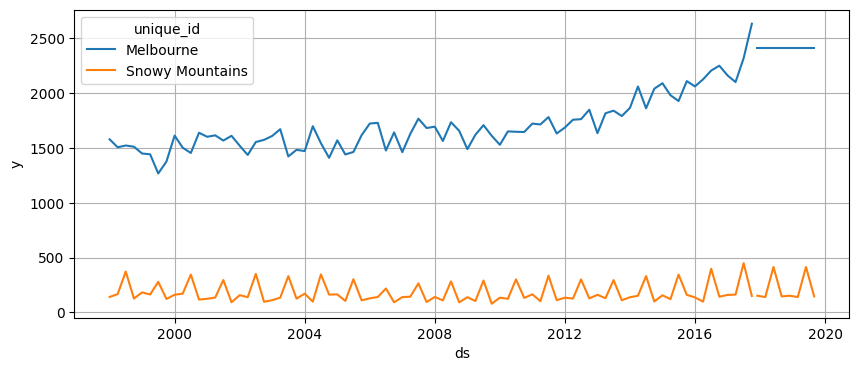

In [107]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(dfp, x="ds", y="y", hue="unique_id", legend=None, ax=ax)
sns.lineplot(dfp2, x="ds", y="AutoARIMA", hue="unique_id", ax=ax)

ax.grid(2)

#### 15. Consider the number of Snowshoe Hare furs traded by the Hudson Bay Company between 1845 and 1935 (data set pelt).

#####  a) Produce a time plot of the time series.

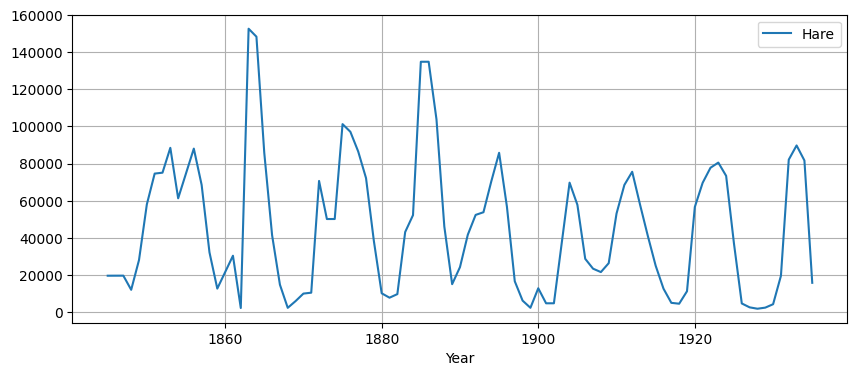

In [224]:
df = pd.read_csv("../data/pelt.csv", index_col=[0])

df.plot(x="Year", y="Hare", figsize=(10, 4), grid=2);

##### b) Assume you decide to fit the following model:

$y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \phi_4 y_{t-4} + \varepsilon_t,$

ARIMA(4, 0, 0)

##### c) By examining the ACF and PACF of the data, explain why this model is appropriate.

Maybe AR(2) because PACF show only two significant spikes, but have more two lags (3, 4) little hard to see.

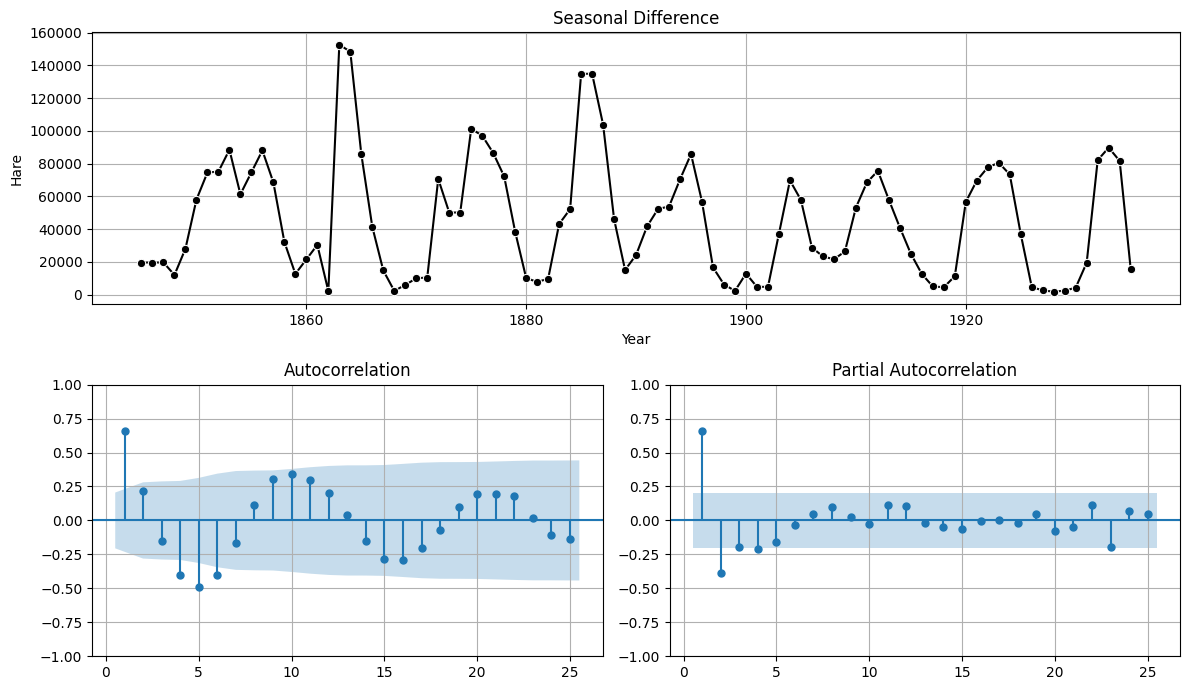

In [113]:
plot_ts_acf(df, x="Year", y="Hare")

In [114]:
a = pm.ARIMA(
    order=(4, 0, 0),
    seasonal_order=(0, 0, 0, 0)
).fit(df["Hare"])

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -1045.947
Date:                Sat, 23 Dec 2023   AIC                           2103.894
Time:                        16:33:04   BIC                           2118.959
Sample:                             0   HQIC                          2109.972
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.215e+04   4587.329      7.007      0.000    2.32e+04    4.11e+04
ar.L1          0.8108      0.121      6.678      0.000       0.573       1.049
ar.L2         -0.2881      0.187     -1.542      0.123      -0.654       0.078
ar.L3         -0.0051      0.167     -0.030      0.976      -0.332       0.322
ar.L4         -0.2269      0.132     -1.718      0.086      -0.486       0.032
sigma2      5.699e+08      0.290   1.96e+09      0.000     5.7e+08     5.7e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               416.57
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             2.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.78e+25. Standard errors may be unstable.
"""

##### d) The last five values of the series are given below:

In [251]:
c = 30993
phi1 = 0.82
phi2 = -0.29
phi3 = -0.01
phi4 = -0.22

e = np.random.normal(size=len(df))
y = df["Hare"].to_numpy().copy()

In [247]:
y

array([ 19580,  19600,  19610,  11990,  28040,  58000,  74600,  75090,
        88480,  61280,  74670,  88060,  68510,  32190,  12640,  21490,
        30350,   2180, 152650, 148360,  85810,  41410,  14750,   2280,
         5910,   9950,  10440,  70640,  50120,  50130, 101250,  97120,
        86510,  72170,  38320,  10110,   7740,   9670,  43120,  52210,
       134850, 134860, 103790,  46100,  15030,  24200,  41650,  52340,
        53780,  70400,  85810,  56690,  16590,   6160,   2300,  12820,
         4720,   4730,  37220,  69720,  57780,  28680,  23370,  21540,
        26340,  53100,  68480,  75580,  57920,  40970,  24950,  12590,
         4970,   4500,  11210,  56600,  69630,  77740,  80530,  73380,
        36930,   4640,   2540,   1800,   2390,   4230,  19520,  82110,
        89760,  81660,  15760])

In [252]:
for i in range(3):
    n = len(y)
    forecast = c + phi1 * y[n - 1] + phi2 * y[n - 2] + phi3 * y[n - 3] + phi4 * y[n - 4]

    y = np.append(y, forecast)
    
    print(forecast)

1273.0
6902.66
18161.2112


##### e) Now fit the model in R and obtain the forecasts using forecast(). How are they different from yours? Why?

I do not know too.

I need to go deeper and check the pmdarima package. 

In [245]:
# Model Params
c = 3.215e+04
phi1 = 0.8108
phi2 = -0.2881
phi3 = -0.0051
phi4 = -0.2269

e = np.random.normal(size=len(df))
y = df["Hare"].to_numpy().copy()

for i in range(3):
    n = len(y)
    forecast = c + phi1 * y[n - 1] + phi2 * y[n - 2] + phi3 * y[n - 3] + phi4 * y[n - 4]

    y = np.append(y, forecast)
    
    print(forecast)

2313.426999999996
8702.260611599999
19930.26458518529


In [242]:
a.predict(3)

91     2311.323361
92     8695.968249
93    19918.735092
dtype: float64

#### 16. The population of Switzerland from 1960 to 2017 is in data set global_economy.

In [259]:
df = pd.read_csv("../data/global_economy.csv", index_col=[0])

df = df[df.Country == "Switzerland"].reset_index(drop=True)

##### a) Produce a time plot of the data.

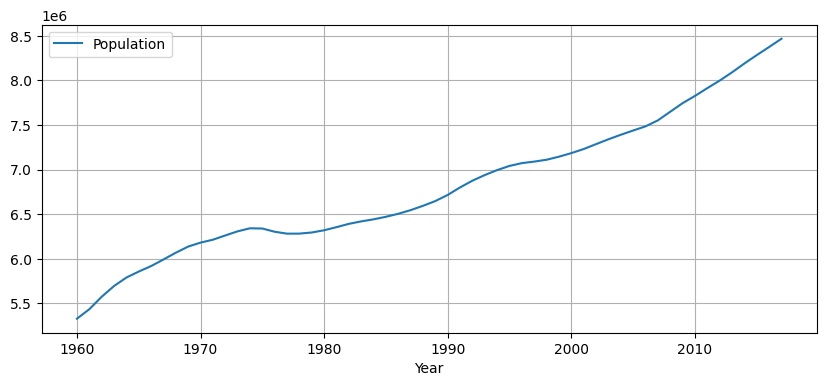

In [264]:
df.plot(
    x="Year", y="Population", grid=2, figsize=(10, 4)
);

##### b) You decide to fit the following model to the series.

$y_t = c + y_{t-1} + \phi_1 (y_{t-1} - y_{t-2}) + \phi_2 (y_{t-2} - y_{t-3}) + \phi_3( y_{t-3} - y_{t-4}) + \varepsilon_t$

ARIMA(3, 1, 0) because is one differencing and have 3 lower phi terms, Non seasonal AR(3).

In [298]:
a = pm.ARIMA(
    order=(3, 1, 0),
    seasonal_order=(0, 0, 0, 0)
).fit(df["Population"])

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1323.984
Date:                Sat, 23 Dec 2023   AIC                           2657.968
Time:                        17:27:03   BIC                           2668.183
Sample:                             0   HQIC                          2661.938
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4409.3387    278.635     15.825      0.000    3863.224    4955.453
ar.L1          0.0231      0.001     35.485      0.000       0.022       0.024
ar.L2          0.0297      0.001     44.029      0.000       0.028       0.031
ar.L3          0.0258      0.001     36.991      0.000       0.024       0.027
sigma2      9.702e+07      0.094   1.03e+09      0.000     9.7e+07     9.7e+07
===================================================================================
Ljung-Box (L1) (Q):                  35.17   Jarque-Bera (JB):                 3.09
Prob(Q):                              0.00   Prob(JB):                         0.21
Heteroskedasticity (H):               2.38   Skew:                            -0.57
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.37e+31. Standard errors may be unstable.
"""

##### c) Explain why this model was chosen using the ACF and PACF of the differenced series.

With ar(3) i need to look on PACF, have three spikes on PACF in lag 1, 2, 3.

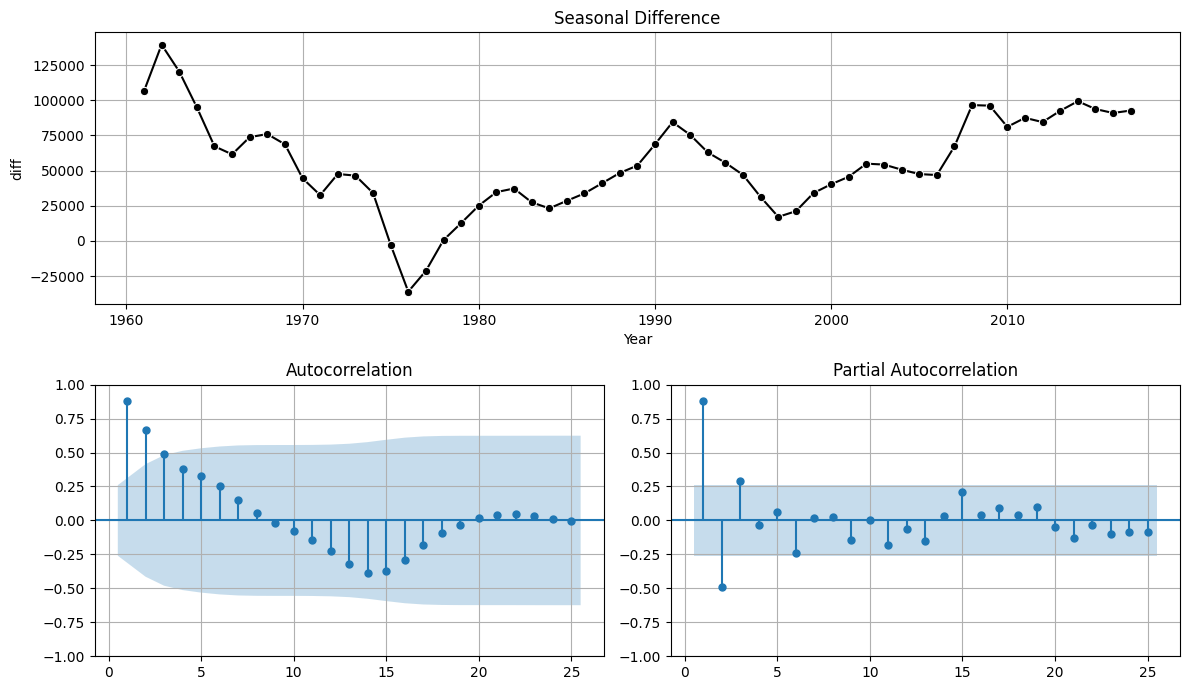

In [296]:
df["diff"] = df["Population"].diff()

plot_ts_acf(df, x="Year", y="diff")

I suggest a secong order differencing because the series looks like no stationary.
Two diff in series with arima(0, 2, 1) because have one significant spike on lag 1 on ACF.
Or arima(2, 2, 0) because have two significant spikes on PACF.

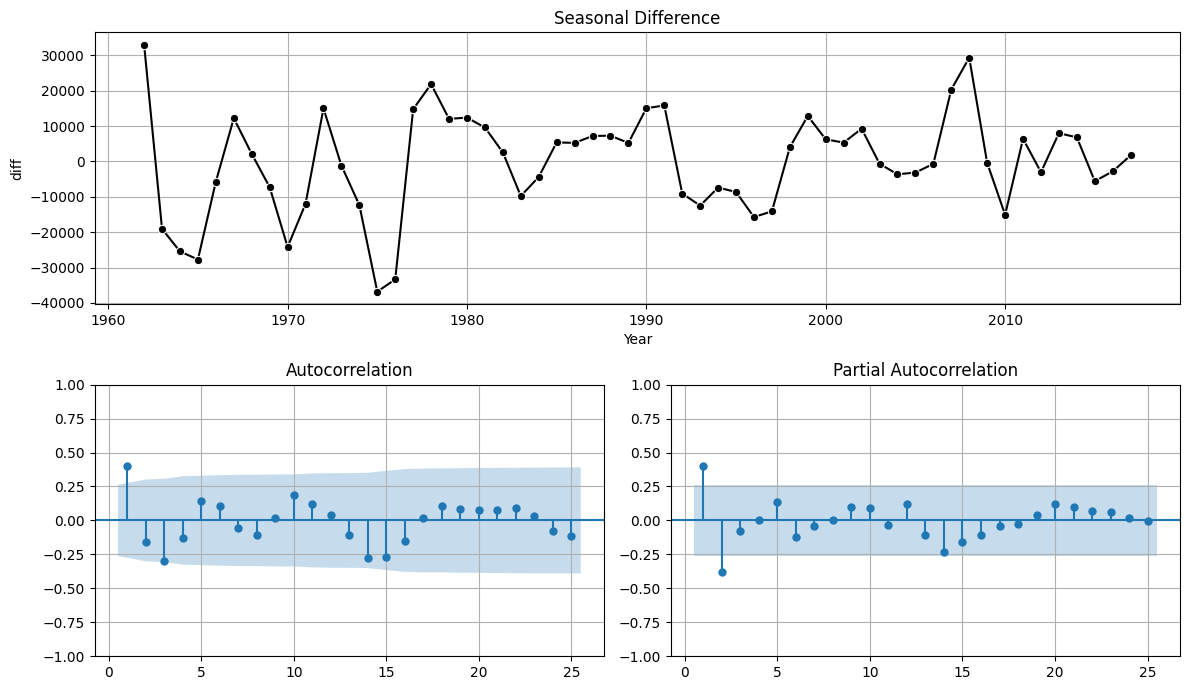

In [297]:
df["diff"] = df["Population"].diff().diff()

plot_ts_acf(df, x="Year", y="diff")

##### d) Produce a time plot of the data.The last five values of the series are given below.

The estimated parameters are  

c=0.0053

ϕ1=1.64

ϕ2=−1.17

ϕ3=0.45.


Without using the forecast() function, calculate forecasts for the next three years (2018–2020).

In [321]:
c = 0.0053
phi1 = 1.64
phi2 = -1.17
phi3 = 0.45

e = np.random.normal(size=len(df))
y = df["Population"].to_numpy().copy()

In [322]:
for i in range(3):
    n = len(y)
    forecast = c + phi1 * y[n - 1] + phi2 * y[n - 2] + phi3 * y[n - 3] + e[n - 1 - i]

    y = np.append(y, forecast)
    
    print(forecast)

7814541.065730199
6678610.003527726
5619615.454611336


##### e) Now fit the model in R and obtain the forecasts from the same model. How are they different from yours? Why?

In [323]:
a.predict(3).to_dict()

{58: 8477692.659966035, 59: 8487478.776379103, 60: 8494856.78259967}